# Машинное обучение, ФКН ВШЭ

## Практическое задание 4. Классификация

### Общая информация
Дата выдачи: 04.11.2022

Мягкий дедлайн: 23:59MSK 16.11.2022

Жесткий дедлайн: 23:59MSK 23.11.2022

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели

----

#### Самостоятельная оценка результатов

Для удобства проверки, исходя из набора решенных задач, посчитайте свою максимальную оценку.

**Оценка**: 7-8

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного жёсткого дедлайна нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи

Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-04-linclass-__Username__.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-04-linclass-__IvanovIvan__.ipynb).

# Часть 1. SVM, LR и калибровка вероятностей

In [2]:
# !pip3 install --upgrade scikit-learn

xcrun: error: invalid active developer path (/Library/Developer/CommandLineTools), missing xcrun at: /Library/Developer/CommandLineTools/usr/bin/xcrun


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

%config InlineBackend.figure_format = 'retina'
sns.set(style='darkgrid', palette='deep')

plt.rcParams['figure.figsize'] = 12, 6
plt.rcParams['font.size'] = 12

#### __Задание 1.1  Сравнение методов__ (0.5 балла)



Сгенерируем синтетические данные.

In [2]:
# фиксируем random_state для воспроизводимости результатов
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

__Случайный классификатор__

Для начала зададим самую простую модель, которая на каждом объекте выдаёт один из двух классов с равными вероятностями. По тестовой выборке вычислим AUC-ROC, AUC-PR.

In [3]:
np.random.seed(42)

# наш случайный классификатор
y_random = np.random.choice([0, 1], size=len(y_test), p=[0.5, 0.5])
y_random

array([0, 1, 1, ..., 0, 0, 1])

*Ниже приведен **пример** работы* со встроенными функциями `sklearn` для отрисовки ROC и PR кривых, сохранения метрик. Пайплайн можно изменять как вам удобно, за особенно эффективные или красивые варианты может быть начислен небольшой бонус :)

In [2]:
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

AUC-PR: 0.63340
AUC-ROC: 0.50394


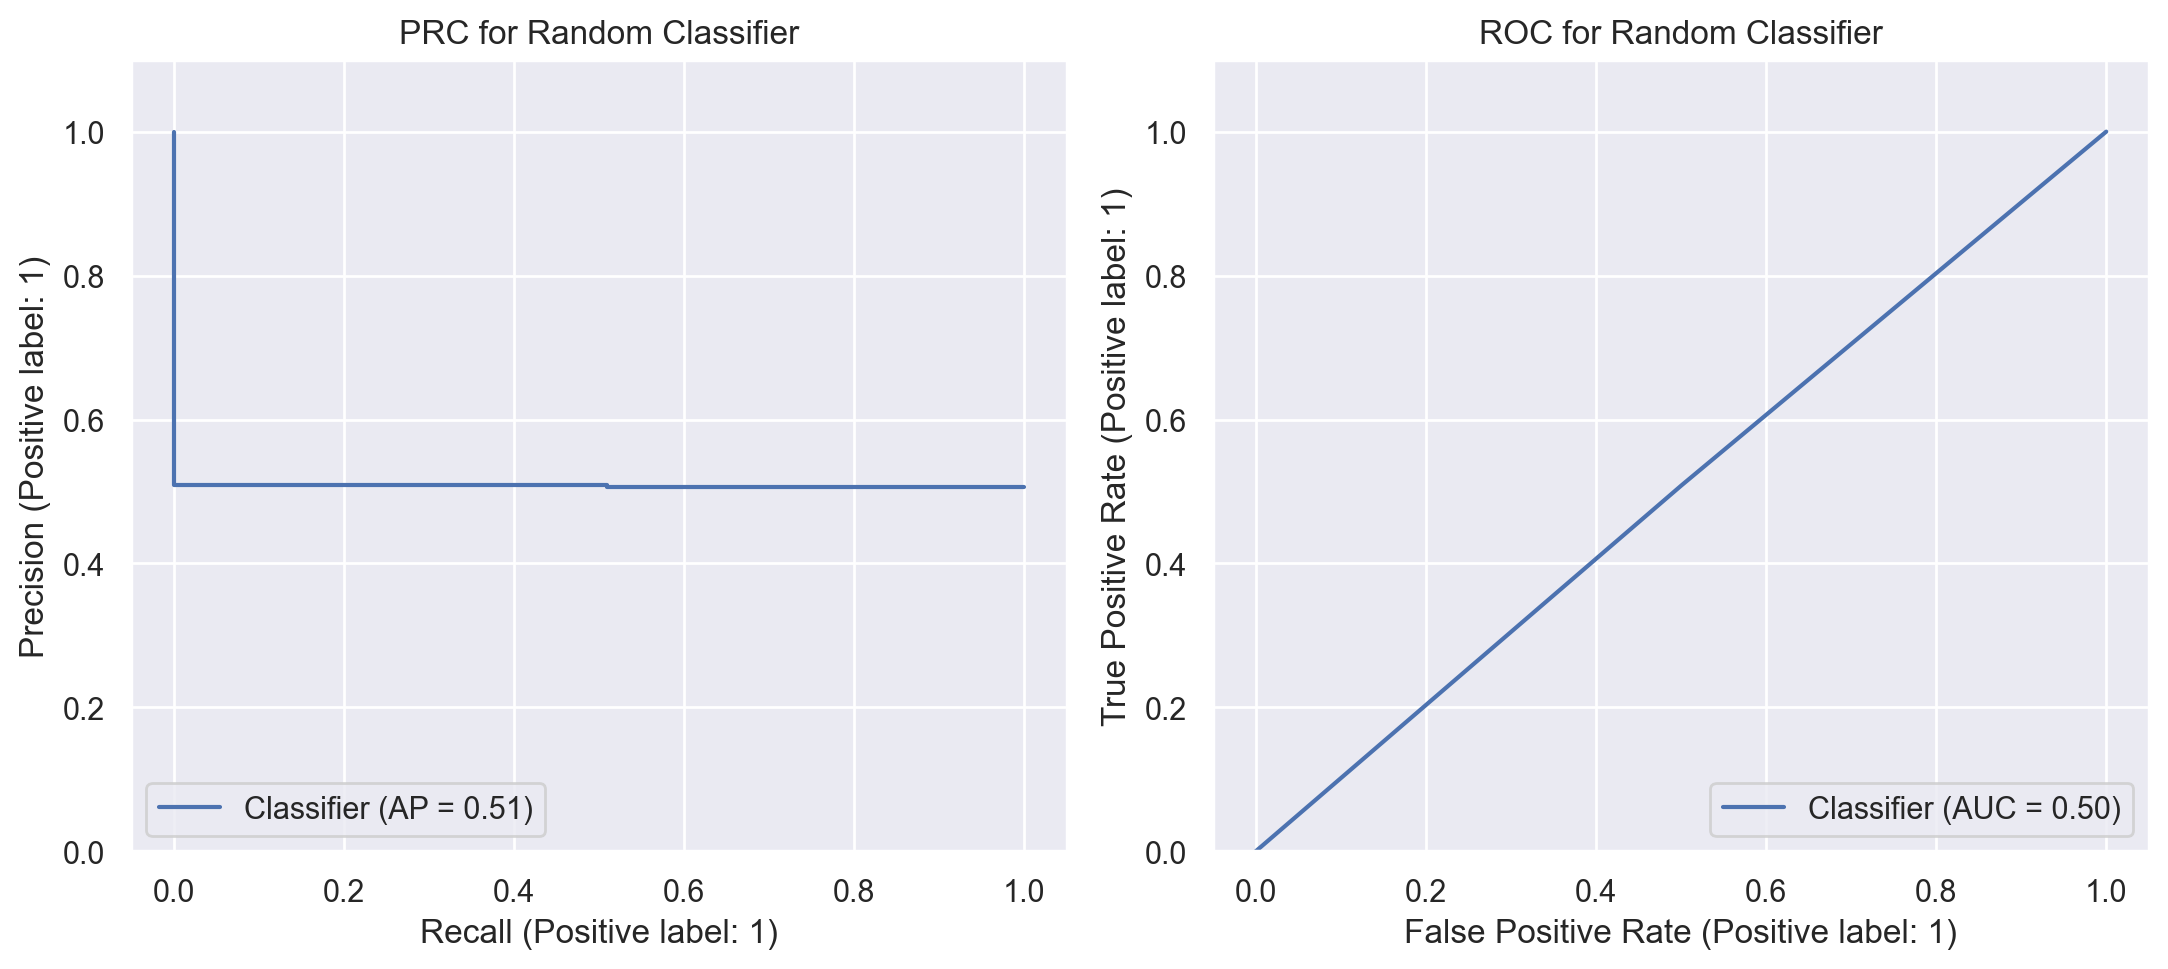

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(11, 5))

PrecisionRecallDisplay.from_predictions(y_test, y_random, ax=ax[0])
precision, recall, _ = precision_recall_curve(y_test, y_random)
print('AUC-PR: %.5f' % auc(recall, precision))
ax[0].set_title("PRC for Random Classifier")
ax[0].set_ylim(0, 1.1)

RocCurveDisplay.from_predictions(y_test, y_random, ax=ax[1])
print('AUC-ROC: %.5f' % roc_auc_score(y_test, y_random))
ax[1].set_title("ROC for Random Classifier")
ax[1].set_ylim(0, 1.1)

plt.tight_layout()

In [6]:
# dataframe для сравнения 
# методов классификации по метрикам
df_metrics = pd.DataFrame(columns=['AUC_PR', 'AUC_ROC', 'reg_const'])

# добавление очередной строки с характеристиками метода
df_metrics.loc['Random Classifier'] = [
    auc(recall, precision),
    roc_auc_score(y_test, y_random),
    None
]

# по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.633402,0.503944,NaN


__Support Vector Machine (Linear Kernel)__

Обучите метод опорных векторов. На занятиях мы проходили линейный вариант без ядрового перехода, что соответствует линейному ядру (`LinearSVC` или же `SVC(kernel='linear')` в `sklearn.svm`). Подберите параметр регуляризации `C` (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей).

__NB!__ Здесь и далее, если не сказано иначе, подбирайте __оптимальные гиперпараметры с точки зрения AUC-PR.__

In [7]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
#обучаю модель
svc = LinearSVC(max_iter=20000).fit(X_train, y_train)
cs = [{'C': np.linspace(0.01, 10, 10)}]
#ищу лучший параметр
grid = GridSearchCV(svc, cs, scoring='average_precision', cv=5)
grid.fit(X_train, y_train)
best_c = grid.best_params_
best_c

/Users/r.berdyshev/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/r.berdyshev/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/r.berdyshev/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/r.berdyshev/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/r.berdyshev/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/r.berdyshev/Library/Python/3.9/li

{'C': 10.0}

  На тестовой части:
  - постройте ROC и PR кривые,
  - посчитайте AUC-ROC, AUC-PR с точностью до 5 знаков

AUC-PR = 0.82964
AUC-ROC = 0.84762


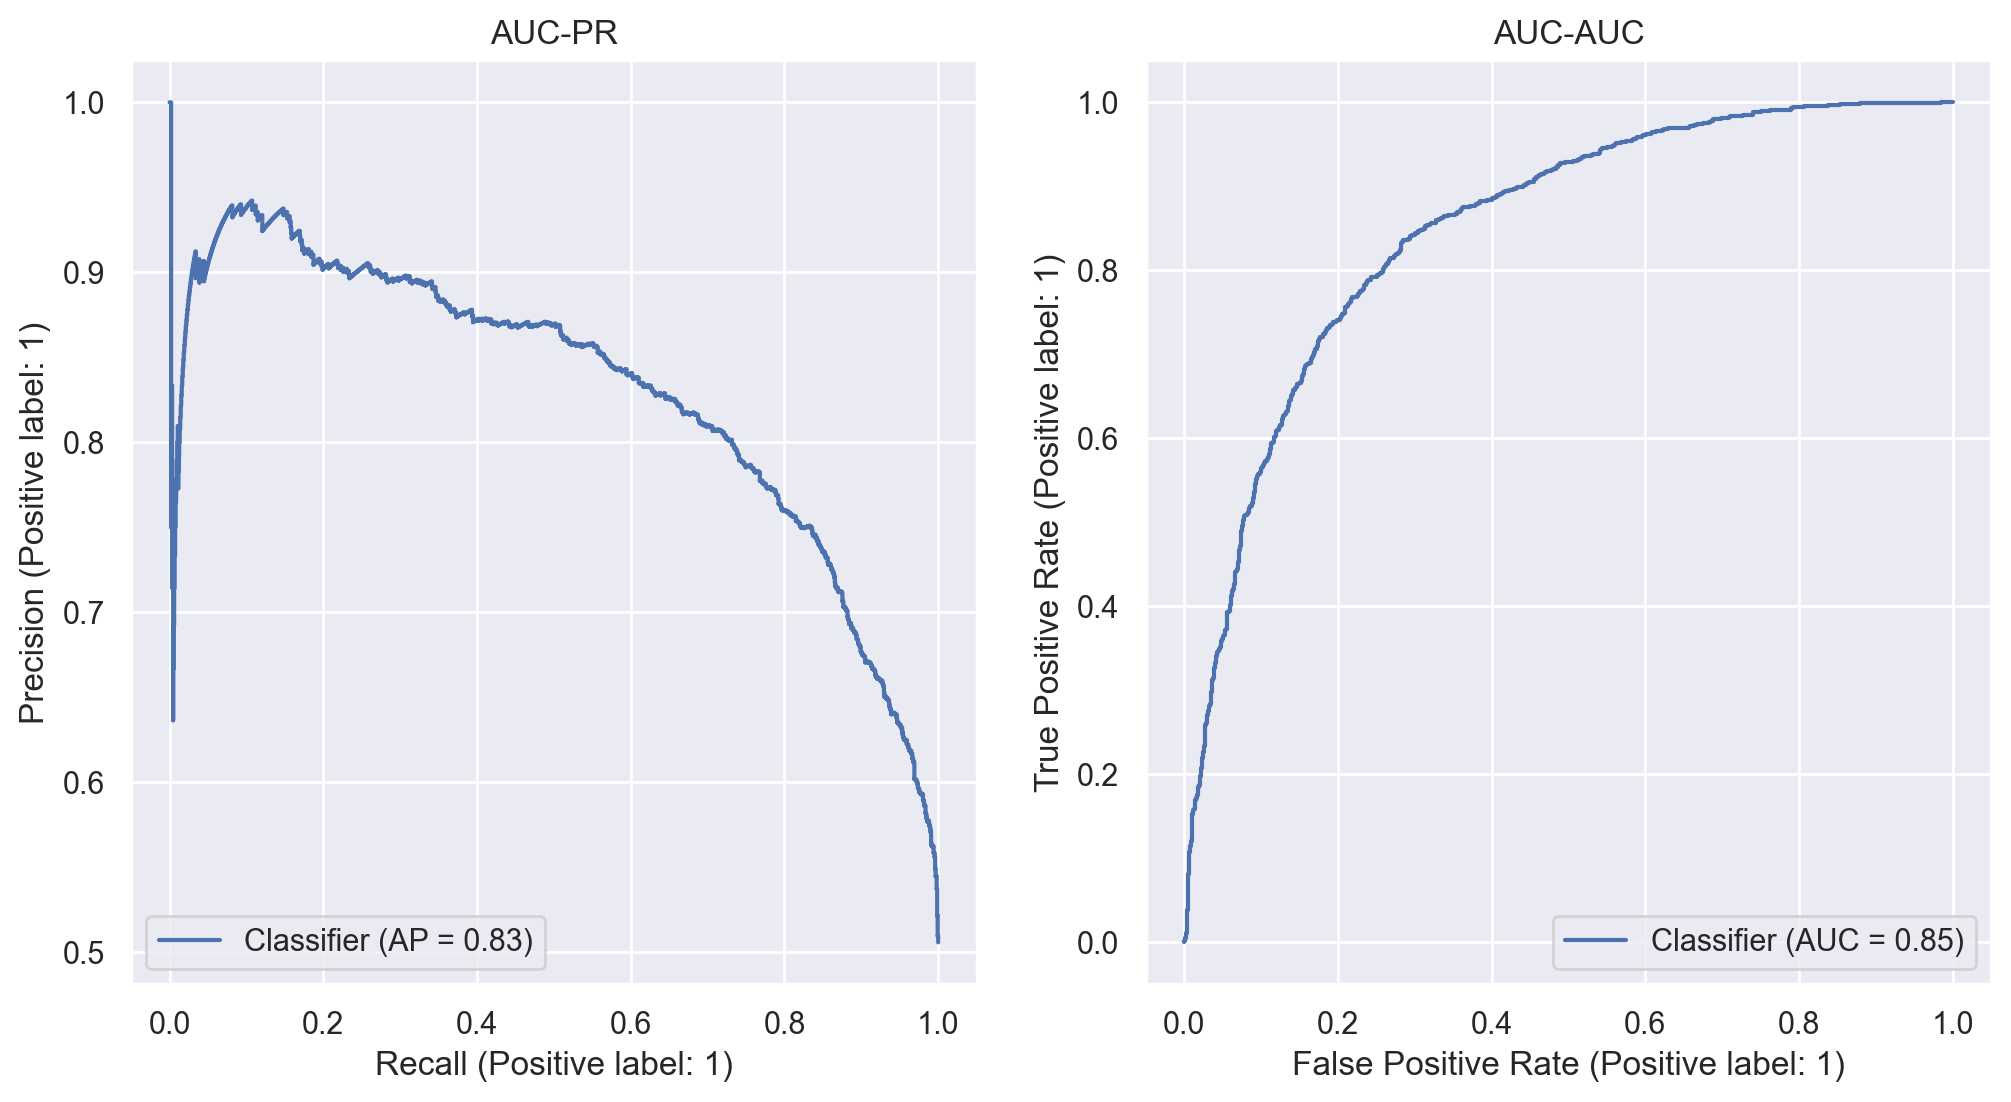

In [8]:
fig, ax = plt.subplots(1,2)

y_pred = grid.best_estimator_.decision_function(X_test)

PrecisionRecallDisplay.from_predictions(y_test, y_pred, ax=ax[0])
ax[0].set_title('AUC-PR')
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
print('AUC-PR = %.5f' % auc(recall, precision))

RocCurveDisplay.from_predictions(y_test, y_pred, ax=ax[1])
ax[1].set_title('AUC-AUC')
print('AUC-ROC = %.5f' % roc_auc_score(y_test, y_pred))

In [9]:
# добавление очередной строки с характеристиками метода
df_metrics.loc['SVM Classifier'] = [
    auc(recall, precision),
    roc_auc_score(y_test, y_pred),
    best_c['C']
]

# по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.633402,0.503944,NaN
SVM Classifier,0.829644,0.847618,10.0


Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора.

Для SVM эти кривые выглядят сильо лучше. PR кривая ближе к правому верхнему углу, а AUC к левому верхнему - это хорошо  

__Logistic Regression__

Теперь повторите то же самое для логистической регрессии (LR) — обучение, подбор параметра регуляризации (используйте L2-регуляризацию), вычисление метрик и построение кривых ROC и PR.

In [10]:
from sklearn.linear_model import LogisticRegression

linear = LogisticRegression().fit(X_train, y_train)
cs = [{'C': np.linspace(0.1, 10, 10)}]
#ищу лучший параметр
grid = GridSearchCV(linear, cs, scoring='average_precision', cv=5)
grid.fit(X_train, y_train)
best_c = grid.best_params_
best_c

{'C': 0.1}

AUC-PR = 0.82917
AUC-ROC = 0.84785


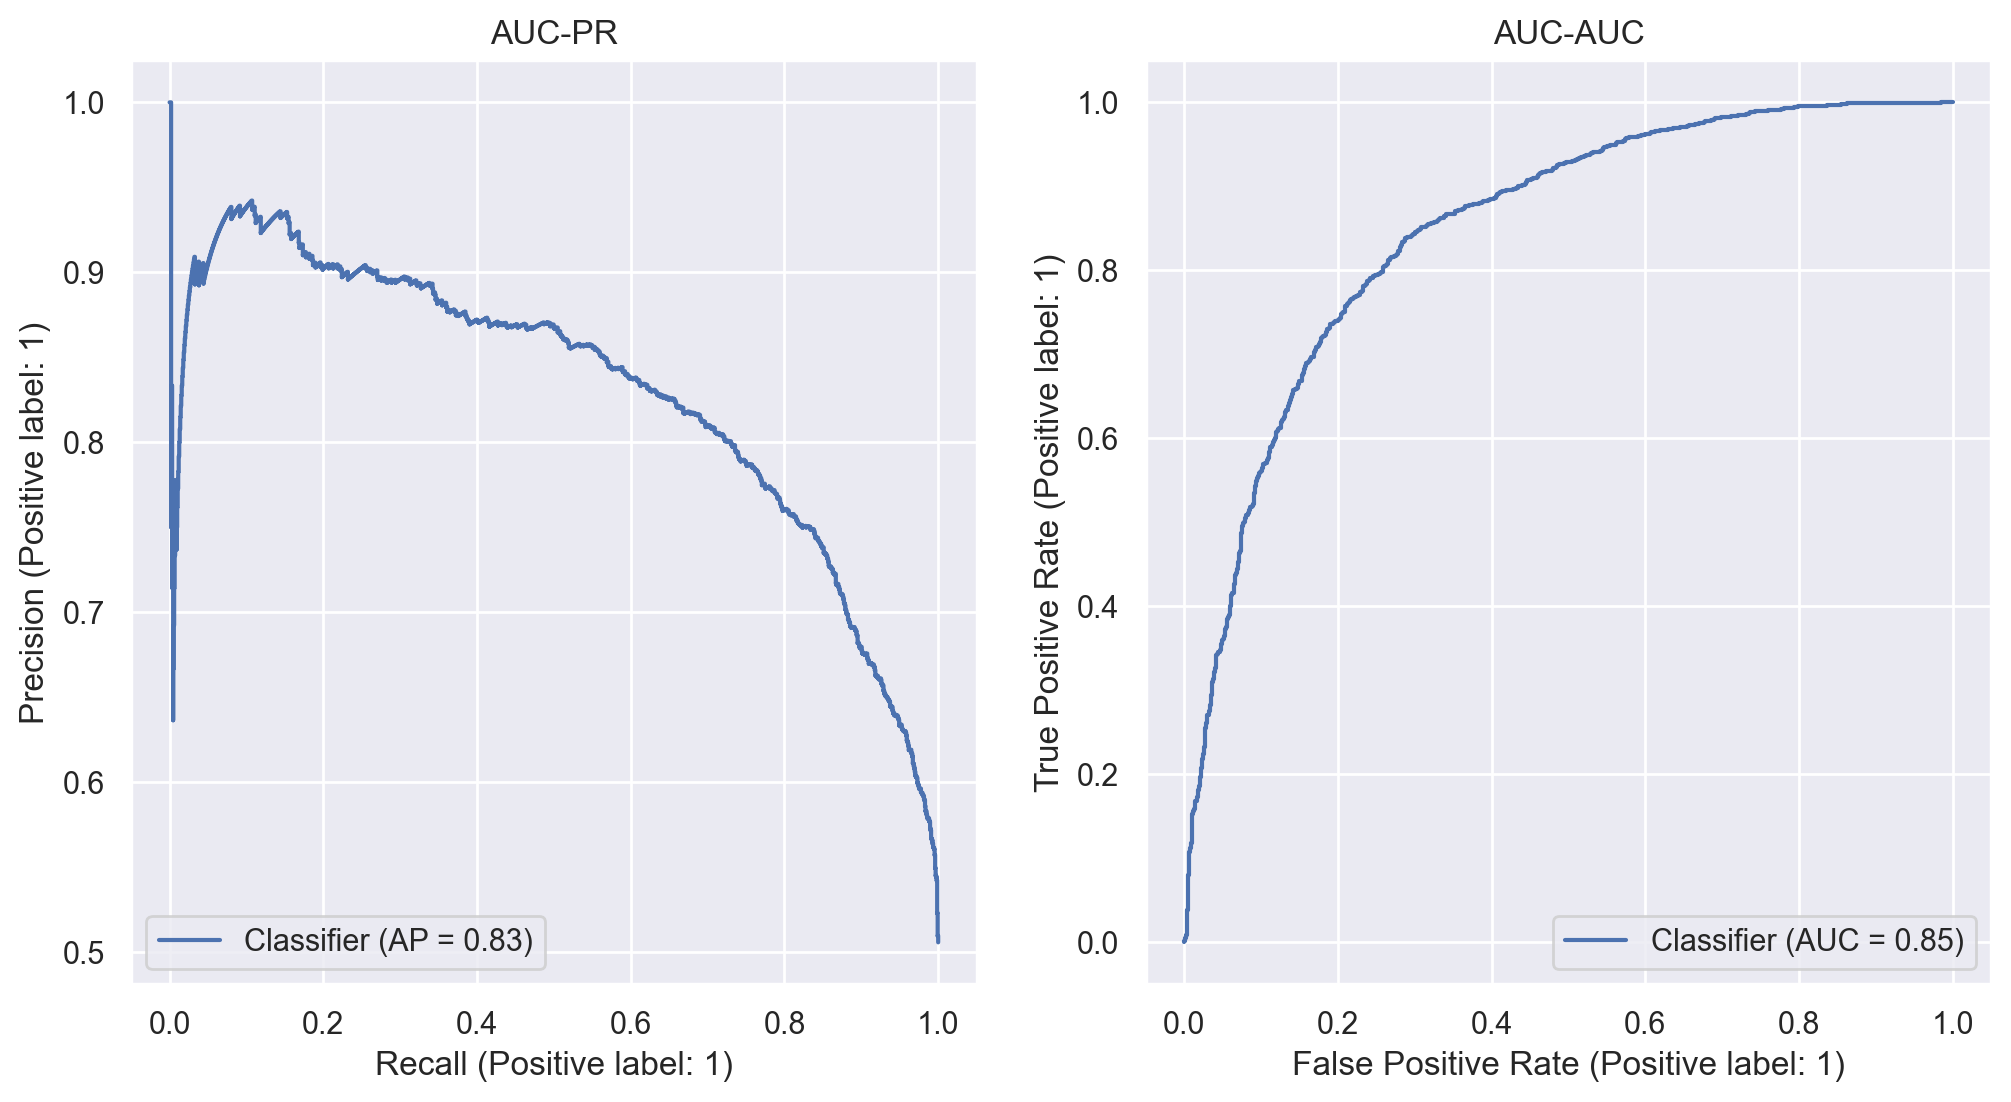

In [11]:
fig, ax = plt.subplots(1,2)

y_pred = grid.best_estimator_.decision_function(X_test)

PrecisionRecallDisplay.from_predictions(y_test, y_pred, ax=ax[0])
ax[0].set_title('AUC-PR')
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
print('AUC-PR = %.5f' % auc(recall, precision))

RocCurveDisplay.from_predictions(y_test, y_pred, ax=ax[1])
ax[1].set_title('AUC-ROC')
print('AUC-ROC = %.5f' % roc_auc_score(y_test, y_pred))

In [12]:
# добавление очередной строки с характеристиками метода
df_metrics.loc['LR Classifier'] = [
    auc(recall, precision),
    roc_auc_score(y_test, y_pred),
    best_c['C']
]

# по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.633402,0.503944,NaN
SVM Classifier,0.829644,0.847618,10.0
LR Classifier,0.829168,0.847846,0.1


__Микровывод__

  Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).

  Ответ: У меня различия между ними совсем минимальные. Графики вообще очень идентичны, немного различаются auc и разные значения для C. Еще чисто эмперическое наблюдение - LR считался гораздо быстрее, чем SVM и

#### __Задание 1.2. Визуализация в подходах SVM, LR__ (0.5 балла)

В названии метода опорных векторов присутствуют некоторые "опорные векторы". По сути, это объекты из обучающей выборки, которые задали положение разделяющей гиперплоскости.

1) Сгенерируйте синтетические данные с помощью `make_classification` __с 2 признаками__, обучите на нём метод опорных векторов. В этот раз воспользуйтесь `SVC(kernel='linear')`, так как только в нём есть информация об опорных векторах, а в `LinearSVC` нет.

2) Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы (атрибут `support_vectors_`). 

In [5]:
X, y = make_classification(n_samples=10000, n_features=2, n_informative=2, n_redundant=0, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

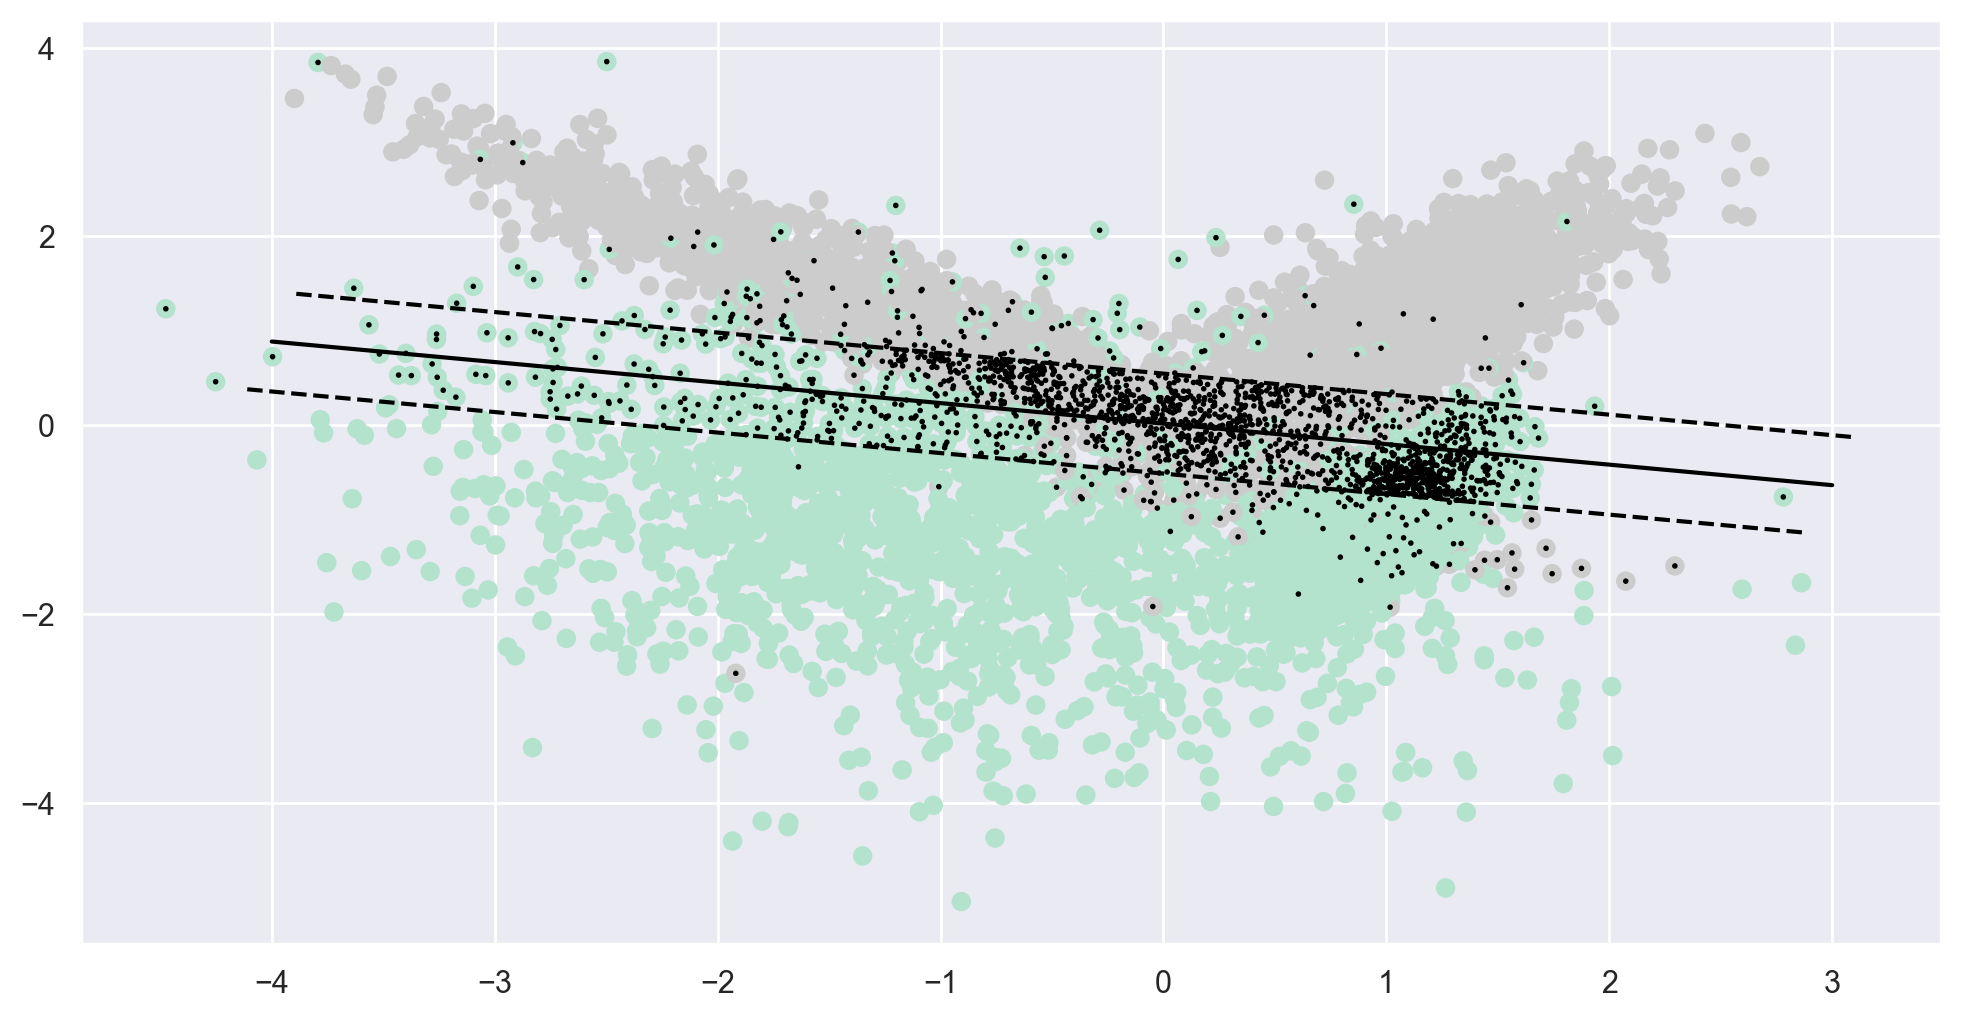

In [15]:
from sklearn.svm import SVC

#обучаем модель
svm_model = SVC(kernel='linear').fit(X_train, y_train)

#распределение точек
plt.scatter(x=X_train[:, 0], y=X_train[:, 1], c=y_train, cmap='Pastel2')

#веса и b
w = svm_model.coef_[0]
b = svm_model.intercept_[0]

#уравнение прямой
x_points = np.linspace(-4, 3)
y_points = -(w[0] * x_points) / w[1] - b / w[1]

plt.plot(x_points, y_points, c='black')

#отступы
w_vector = w / np.sqrt(np.sum(w**2))
margin = 1 / np.sqrt(np.sum(w**2))

#сдвиг прямых
hyperplane = zip(x_points, y_points)
up_points = np.array(list(zip(x_points, y_points))) + w_vector * margin
down_points = np.array(list(zip(x_points, y_points))) - w_vector * margin

#построение границ
plt.plot(up_points[:,0], up_points[:,1], ls = '--', c = 'black')
plt.plot(down_points[:,0], down_points[:,1], ls = '--', c = 'black')

#выделение опорных векторов
plt.scatter(svm_model.support_vectors_[:, 0], svm_model.support_vectors_[:, 1], 
facecolors="none",s = 1, edgecolors='black')

plt.show()

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты. Вам может помочь функция `plt.pcolor` ([matplotlib demo](https://matplotlib.org/3.1.1/gallery/images_contours_and_fields/pcolor_demo.html#sphx-glr-gallery-images-contours-and-fields-pcolor-demo-py)).

Я не очень понял, почему у логрега нет разделяющей плоскости, кажется у всех классификаторов есть разделяющая плоскость. 
Поэтому я решил построить разделяющую плоскость, вдохновлялся [тут](https://scipython.com/blog/plotting-the-decision-boundary-of-a-logistic-regression-model/)

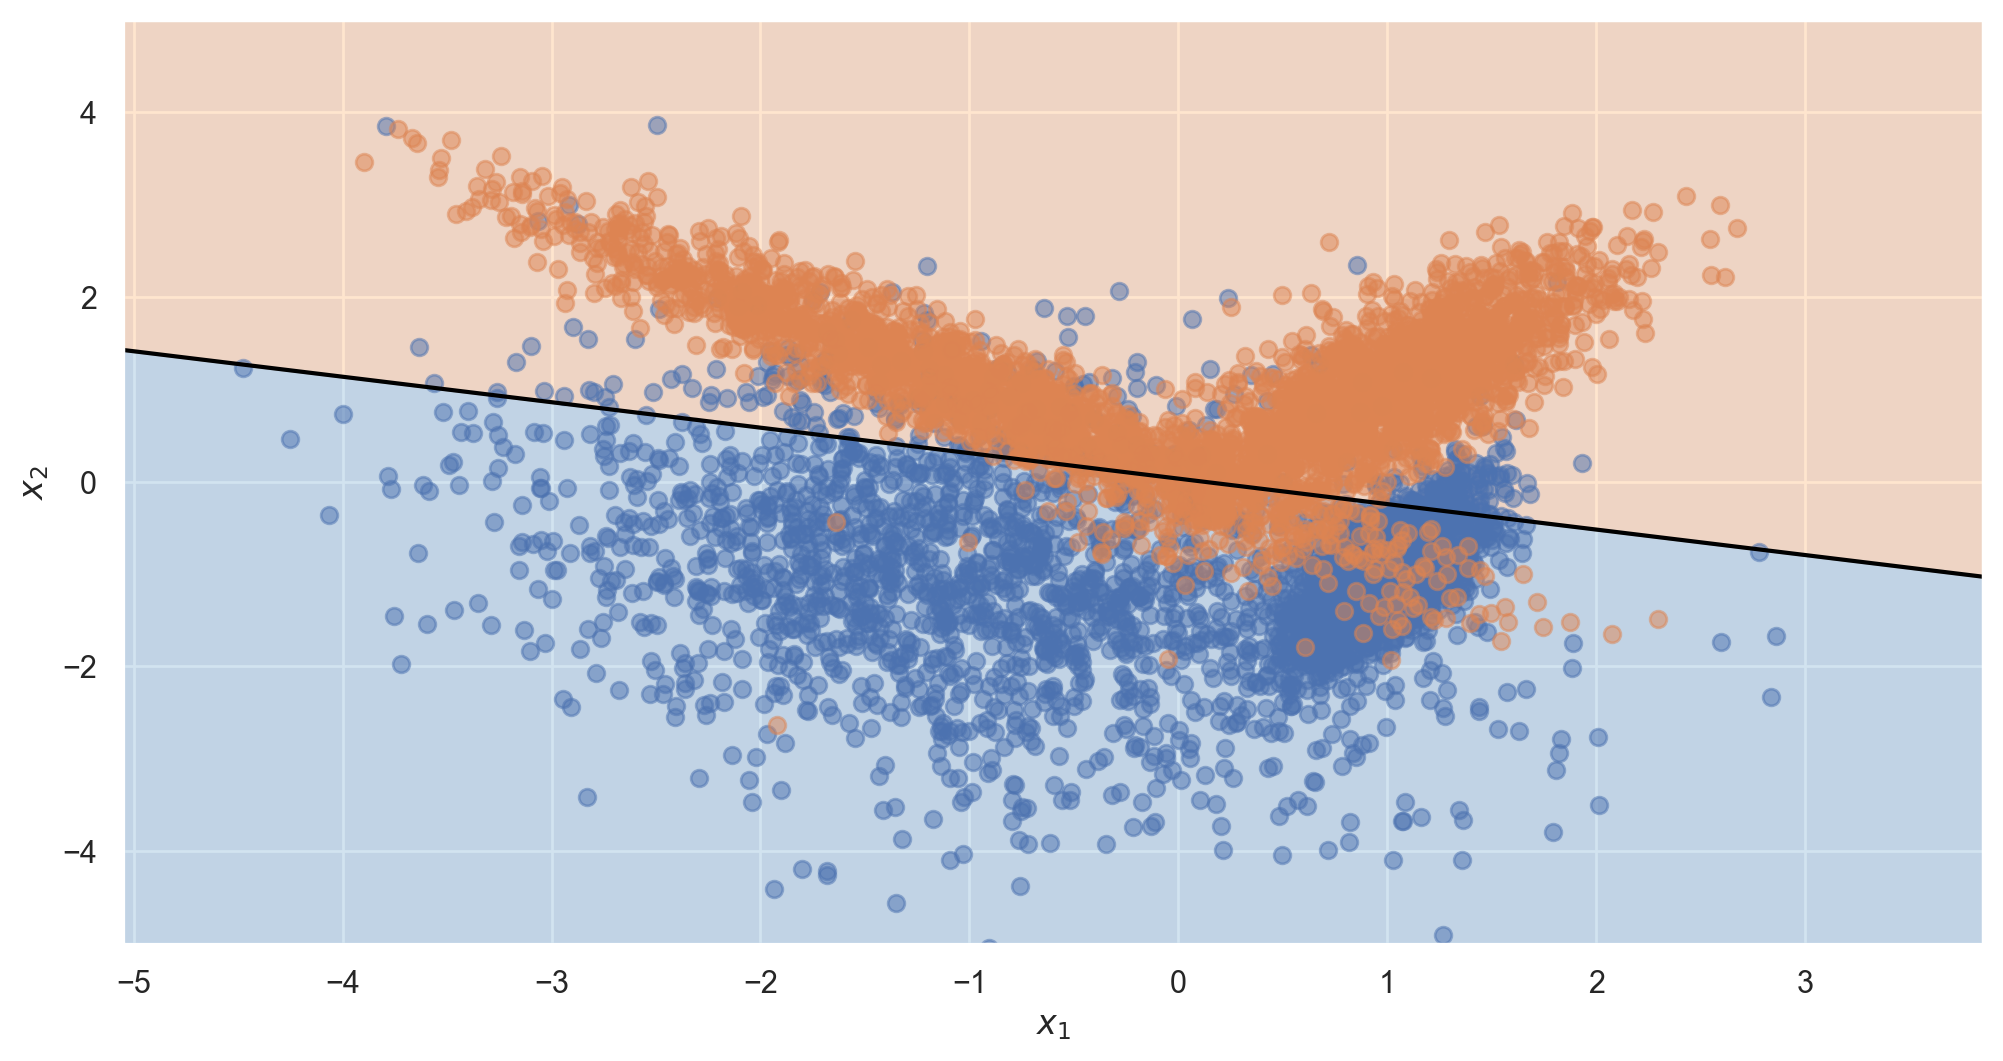

In [11]:
from sklearn.linear_model import LogisticRegression

#обучаемся
clf = LogisticRegression()
clf.fit(X_train, y_train)

#забираем параметры
b = clf.intercept_[0]
w1, w2 = clf.coef_.T
#находим пересечение с осью ординат и угол наклона
c = -b/w2
m = -w1/w2

#задаю уравнение прямой
ymin, ymax = -5, 5
x_points = np.linspace(X_train.min(), X_train.max())
y_points = m*x_points + c
plt.plot(x_points, y_points, c='black')
plt.fill_between(x_points, y_points, ymin, color='tab:blue', alpha=0.2)
plt.fill_between(x_points, y_points, ymax, color='tab:orange', alpha=0.2)

plt.scatter(*X_train[y_train==0].T, alpha=0.5)
plt.scatter(*X_train[y_train==1].T, alpha=0.5)
plt.xlim(x_points[0], x_points[-1])
plt.ylim(ymin, ymax)
plt.ylabel(r'$x_2$')
plt.xlabel(r'$x_1$')

plt.show()

#### __Задание 2. Калибровка вероятностей__ (1 балл)

Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых. 

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность? Для этого разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины.

Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной.

Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [69]:
def plot_calibration_curve(y_test, preds, title, label='classifier'):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2) #1 ошибка - изменил l + 
        bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)] == 1)) #2 ошибка - изменил min на mean
    plt.figure(figsize=(6,6))
    plt.plot(bin_middle_points, bin_real_ratios, label=label)
    plt.plot([0, 1], [0, 1], label='Perfect', linestyle='--', color='green')
    plt.ylim([-0.05, 1.05])
    plt.title(title)
    plt.legend()
    plt.show()

Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$).

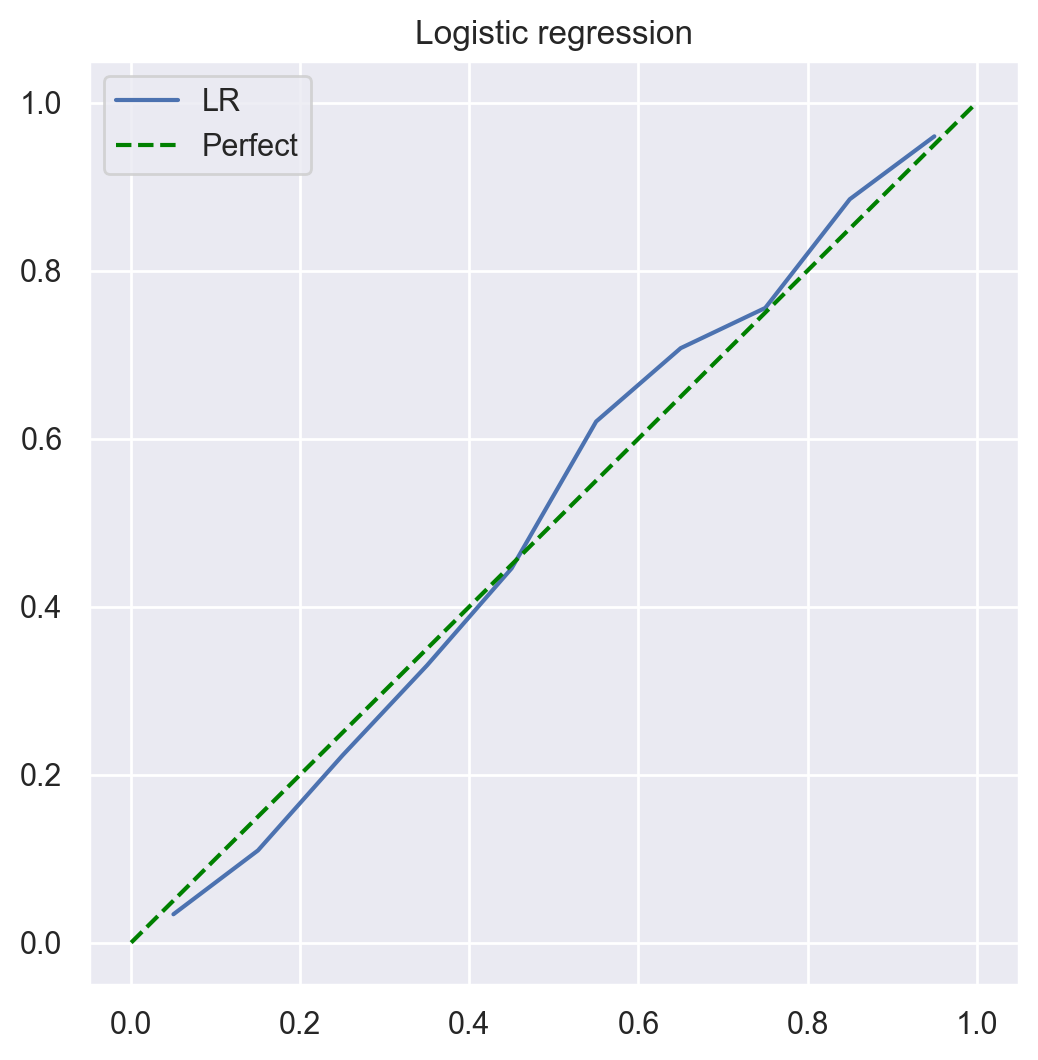

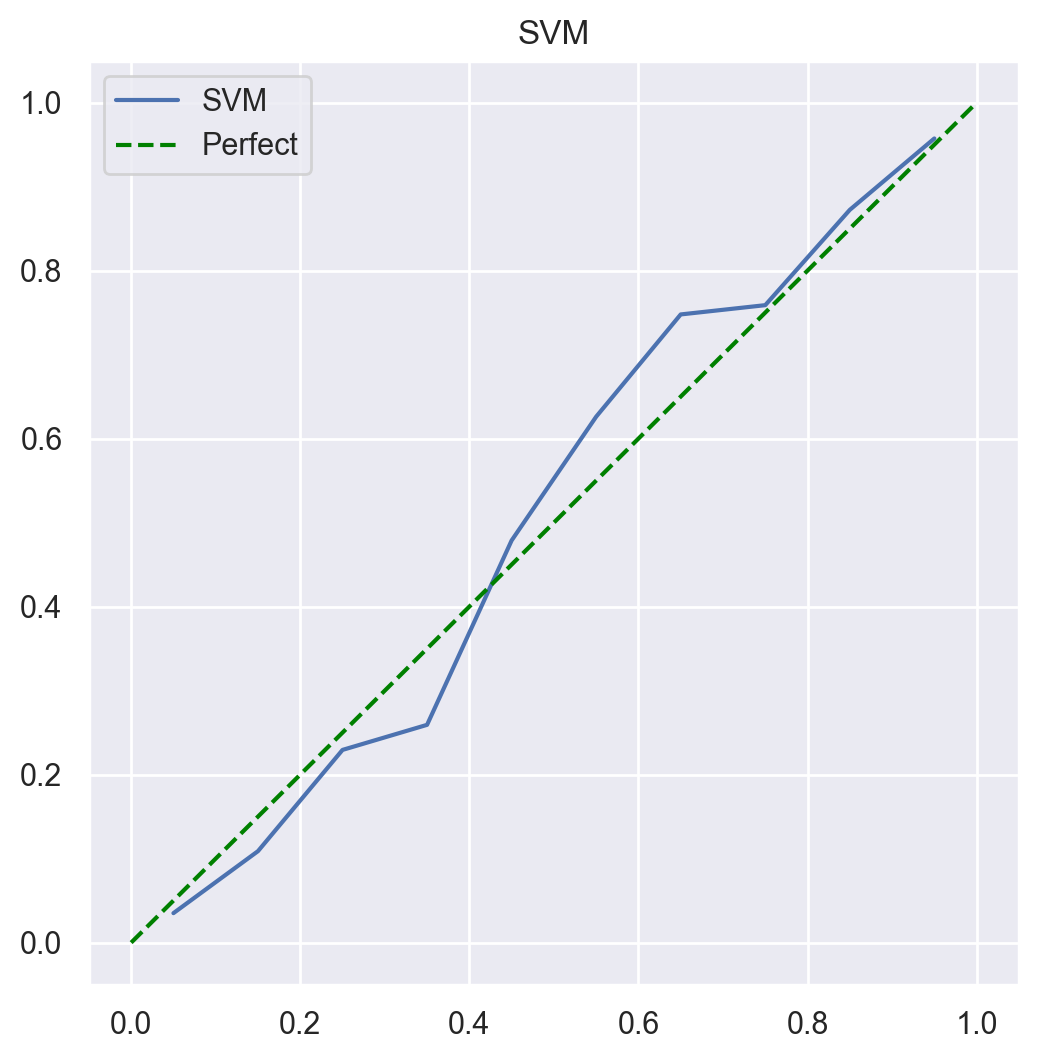

In [70]:
from sklearn.linear_model import LogisticRegression

X, y = make_classification(n_samples=10000, n_features=2, n_informative=2, n_redundant=0, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

log_model = LogisticRegression(random_state=42).fit(X_train, y_train)
y_pred_log = log_model.predict_proba(X_test)
svm_model = SVC(kernel='linear', probability=True).fit(X_train, y_train)
y_pred_svm = svm_model.predict_proba(X_test)

plot_calibration_curve(y_test, y_pred_log[:,1], 'Logistic regression', 'LR')
plot_calibration_curve(y_test, y_pred_svm[:,1], 'SVM', 'SVM')

Изучите распределение ответов классификаторов (постройте гистограммы с помощью `plt.hist`).

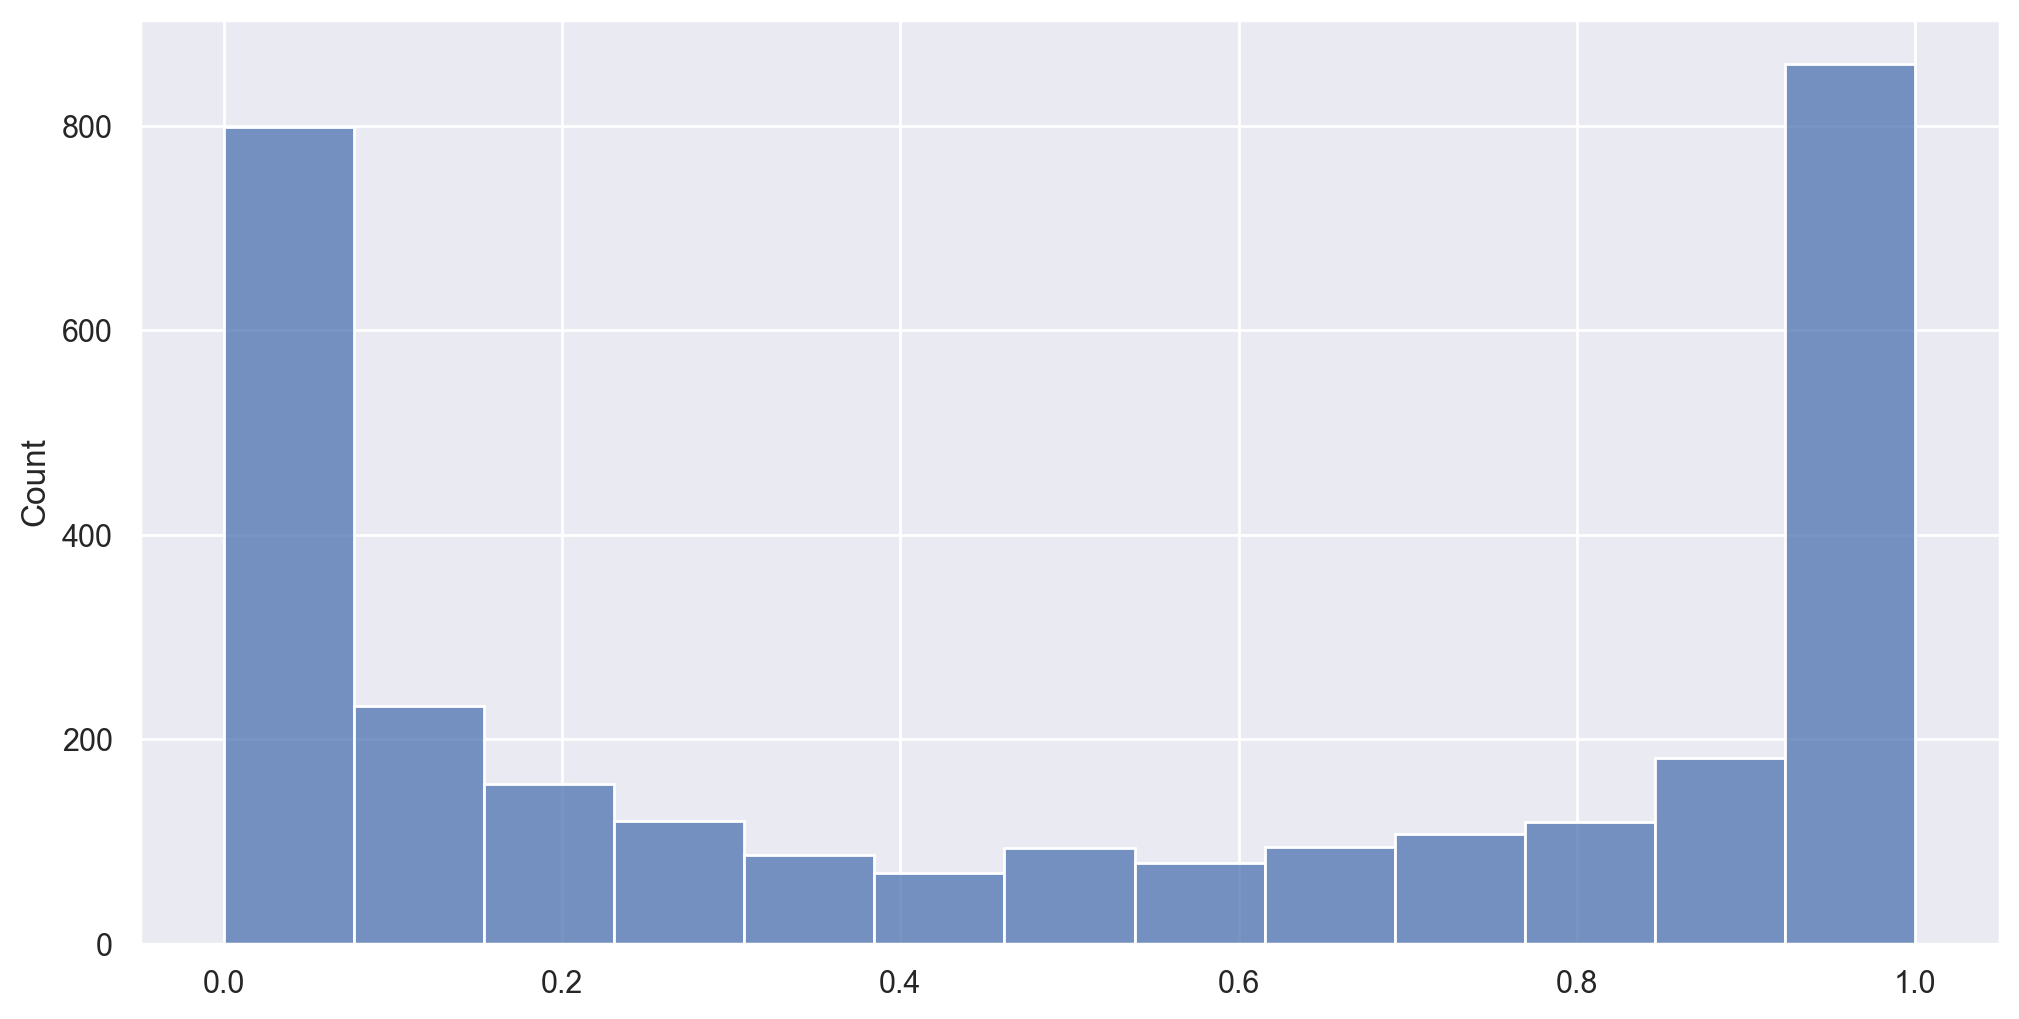

In [53]:
sns.histplot(y_pred_log[:,1])
plt.show()

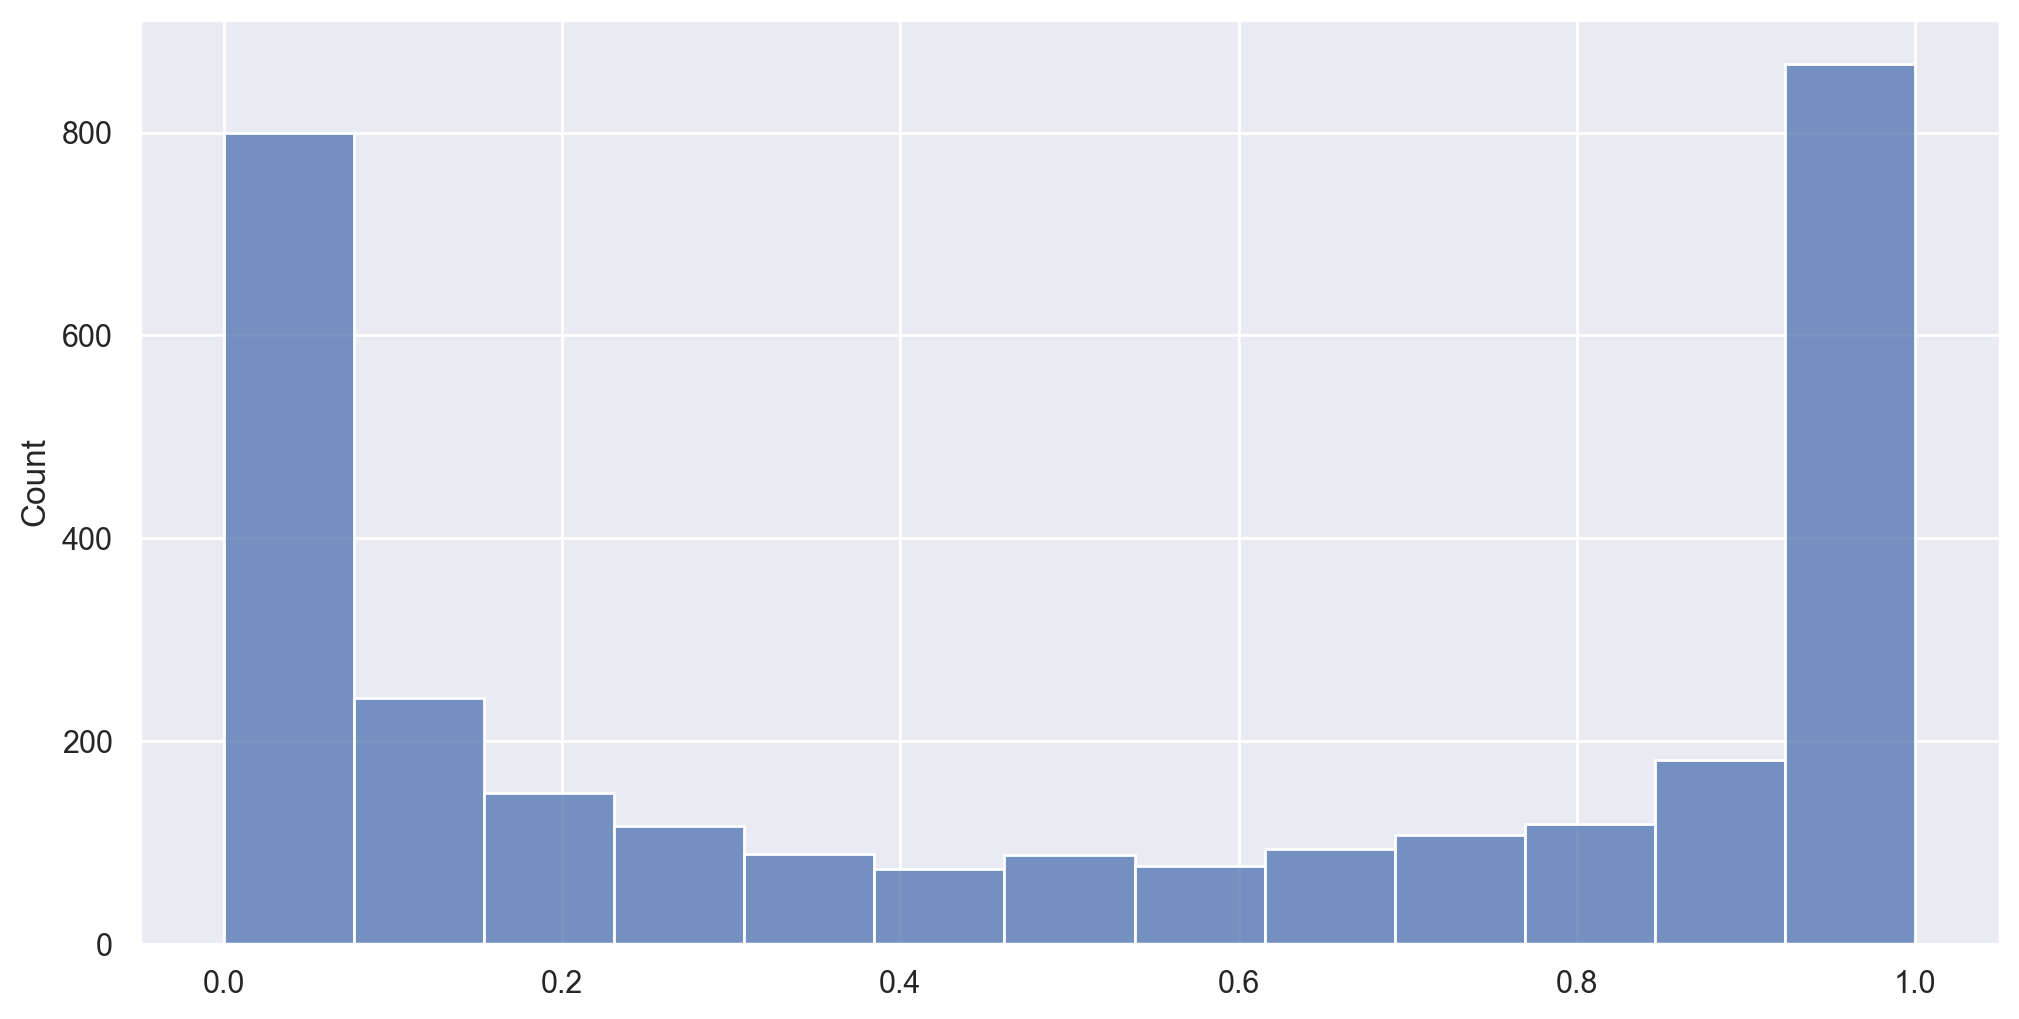

In [54]:
sns.histplot(y_pred_svm[:,1])
plt.show()


Чем они различаются? Чем вы можете объяснить это?

Ответ: у меня они в целом не отличаются. По таким распределениям можно заметить, что модель уверенна в своих предсказаниях. Если он выдает положительный класс, то она достаточно уверенна в этом. С отрицательным классом аналогично

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью предсказания для тестовой выборки. Нарисуйте для них калибровочную кривую. Улучшилась ли она?

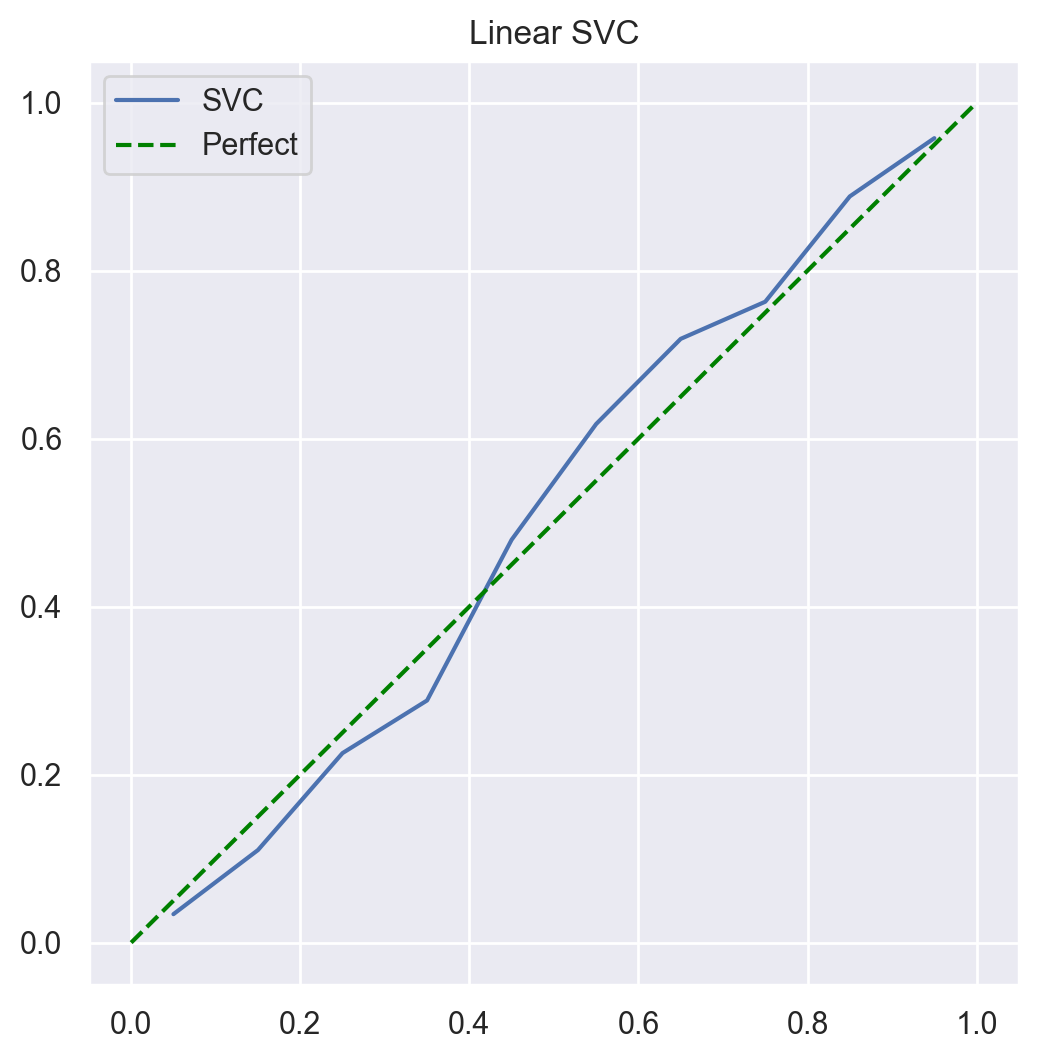

Linear SVC ROC-AUC: 0.9461120612413244


In [76]:
from sklearn.calibration import CalibratedClassifierCV

svm = LinearSVC()
svm_model_classifier = CalibratedClassifierCV(svm).fit(X_train, y_train)
y_pred_classifier = svm_model_classifier.predict_proba(X_test)
plot_calibration_curve(y_test, y_pred_classifier[:,1], 'Linear SVC', 'SVC')
print('Linear SVC ROC-AUC:', roc_auc_score(y_test, y_pred_classifier[:, 1]))

Эта кривая получилась лучше, чем для SVC. Это может быть потому что в LinearSVC используется квадратичный лосс, а в SVC обычная кривая

##### __Бонус: Авторское решение__ (0.5 балла)

Реализуйте свою функцию для калибровки вероятностей, используя любой из известных подходов. Кратко опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

Калибровка Платто основана на сигмоиде:
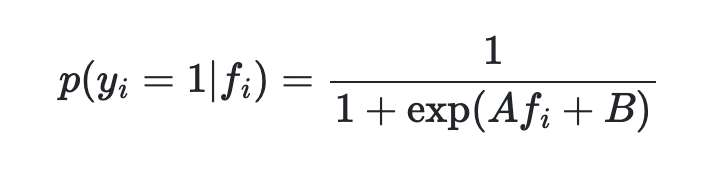

где $f_{i}$ это результат нашего неоткалиброванного классификатора, $y_{i}$ - фактическое значени, а $А$ и $В$ некоторые параметры(числа), которые подбираются с помощью правдоподобия

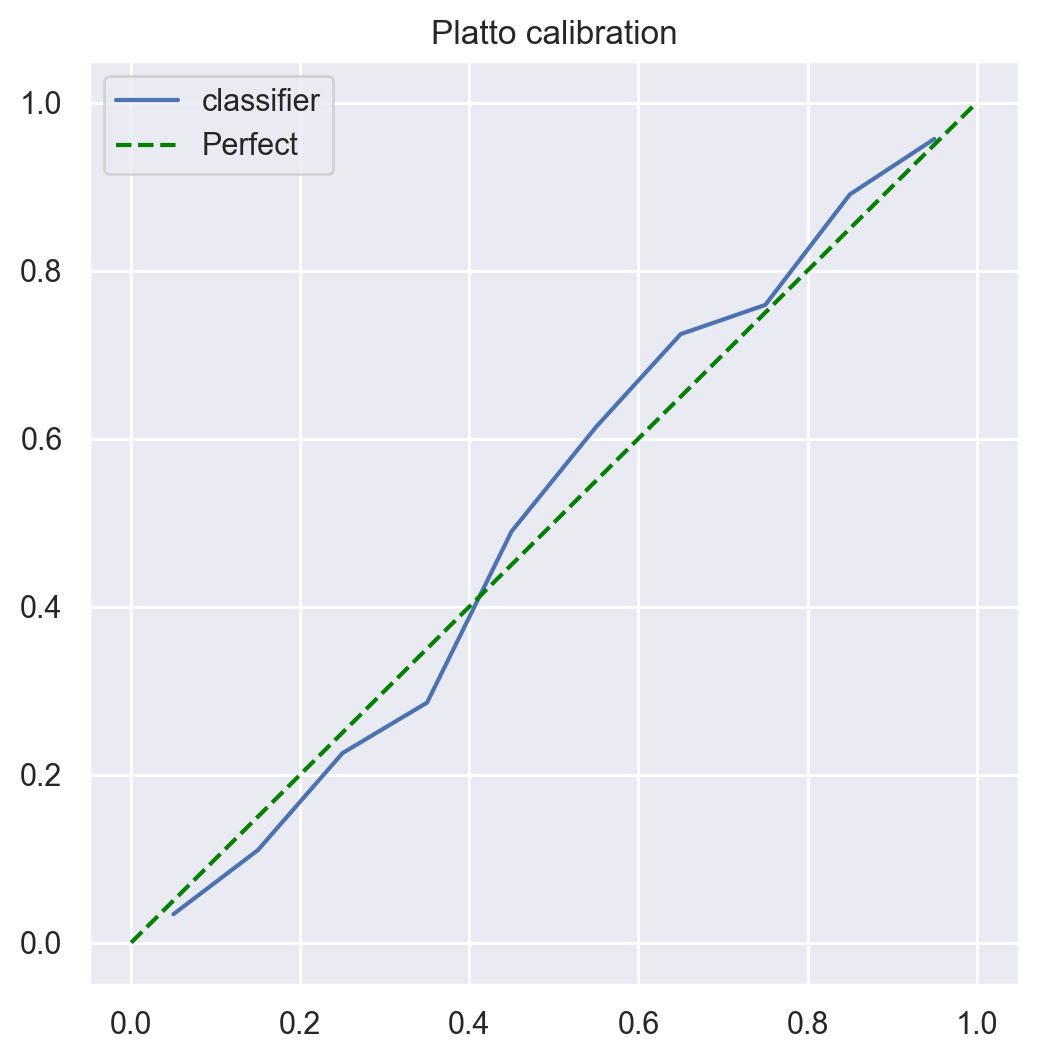

SVC ROC-AUC: 0.946115616822164


In [78]:
svc_plato = CalibratedClassifierCV(svc, cv=3, method='sigmoid').fit(X_train, y_train)
svc_plato_pred = svc_plato.predict_proba(X_test)
plot_calibration_curve(y_test, svc_plato_pred[:, 1], 'Platto calibration')
print('SVC ROC-AUC:', roc_auc_score(y_test, svc_plato_pred[:, 1]))

Изотонический метод использует некую кусочно-линейную возрастающую функцию $f: R \to R$. $f$ подбирается, чтобы минимизировать MSE:
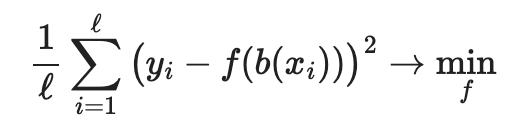

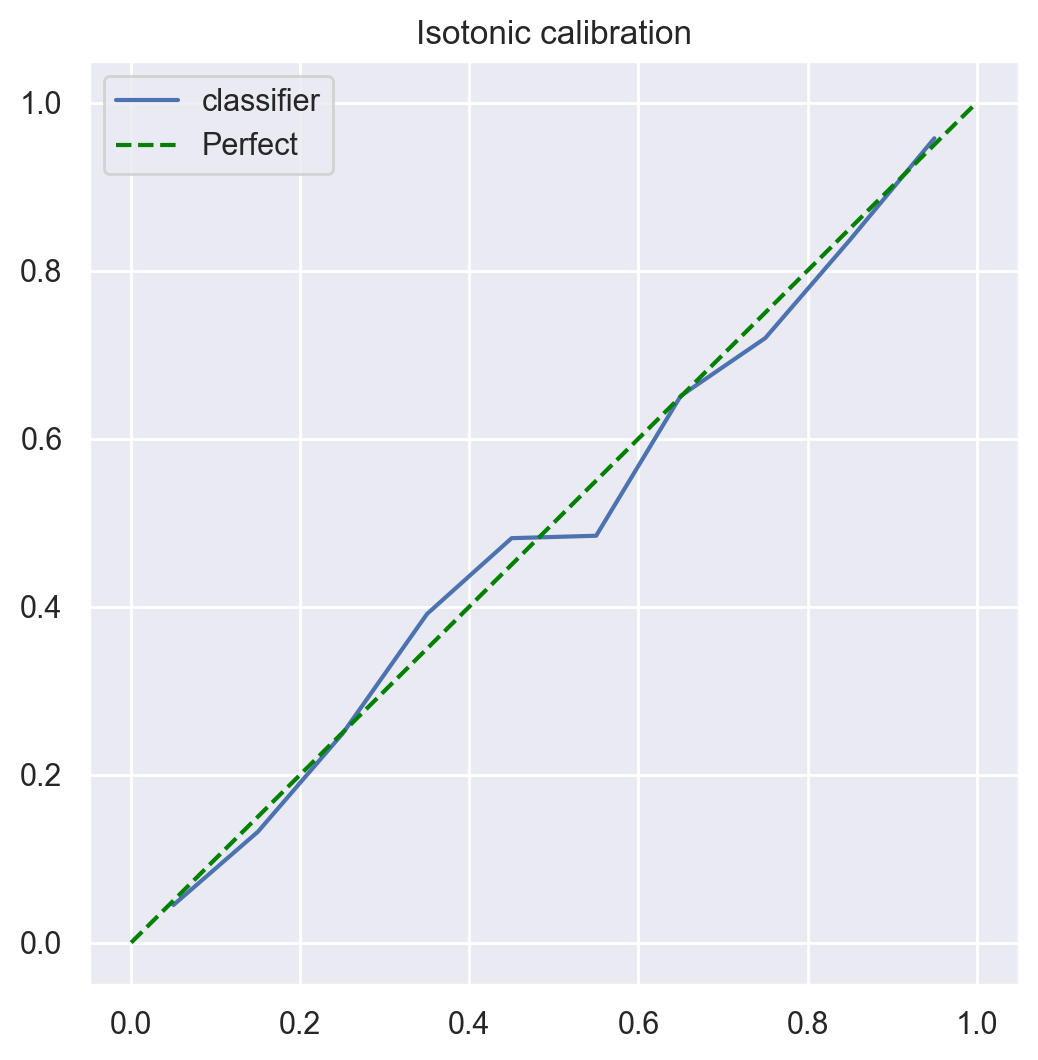

SVC ROC-AUC: 0.9460276161963819


In [79]:
svc_isotonic = CalibratedClassifierCV(svc, cv=3, method='isotonic').fit(X_train, y_train)
svc_isotonic_pred = svc_isotonic.predict_proba(X_test)
plot_calibration_curve(y_test, svc_isotonic_pred[:, 1], 'Isotonic calibration')
print('SVC ROC-AUC:', roc_auc_score(y_test, svc_isotonic_pred[:, 1]))

Платто оказался лучше всех, а изотонический хуже всех, потому что у него есть нюанс - он склонен к переобучению и его лучше применять для больших выборок

# Часть 2. Обработка категориальных переменных

Как мы знаем, перекодировать категориальную переменную в список чисел (к примеру 1, 2, 3, ..., n) плохо, поскольку это бы задало на множестве ее значений некоторый порядок, не имеющий смысла. 

В этой части мы рассмотрим два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

#### __Подготовка данных__

(бесценный шаг)

Загрузим данные [UCI Adult Dataset](https://archive.ics.uci.edu/ml/datasets/Adult). Этот набор данных содержит информацию о годовых доходах отдельных людей. В качестве признакового описания используется различная информация о человеке (образование, профессия, брачный статус и т.д.). Целевая переменная является бинарной: больше ли годовой доход 50K долларов или нет. 

In [1]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

--2022-11-19 09:55:19--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Распознаётся archive.ics.uci.edu (archive.ics.uci.edu)… 128.195.10.252
Подключение к archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 3974305 (3,8M) [application/x-httpd-php]
Сохранение в: «adult.data»

adult.data          100%[===================>]   3,79M   249KB/s    за 14s     

2022-11-19 09:55:35 (269 KB/s) - «adult.data» сохранён [3974305/3974305]



In [326]:
columns = ['age', 'workclass', 'fnlwgt', 'education', 
           'education-num', 'marital-status', 'occupation',
           'relationship', 'race', 'sex', 'capital-gain', 
           'capital-loss', 'hours-per-week', 'native-country',
           'income']

df = pd.read_csv('adult.data', header=None, names=columns)
df['income'] = (df['income'] != " <=50K").astype('int32')

In [327]:
df.sample(5)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
21308,18,Private,137363,12th,8,Never-married,Other-service,Own-child,White,Female,0,0,20,United-States,0
8206,43,Self-emp-inc,260960,Bachelors,13,Divorced,Farming-fishing,Not-in-family,White,Male,0,0,35,United-States,0
12485,22,Private,192017,HS-grad,9,Never-married,Prof-specialty,Not-in-family,White,Male,0,0,40,United-States,0
23399,63,Self-emp-not-inc,28612,HS-grad,9,Widowed,Sales,Not-in-family,White,Male,0,0,70,United-States,0
10647,42,Local-gov,185129,Doctorate,16,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,43,?,1


Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify`. 

In [328]:
y = df['income']
X = df.drop(columns=['income'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)

#### __Задание 3. OrdinalEncoder__  (0.5 балла)

Закодируйте категориальные признаки с помощью `OrdinalEncoder`, а числовые признаки нормализуйте с помощью `StandardScaler`. Посчитайте качество (в этом задании будем работать c __`AUC-PR`__) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели, с учетом кодирования признаков.

In [15]:
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, LinearRegression

In [14]:
#выбираем колонки
cat_columns = list(X_train.select_dtypes('object').columns)
num_columns = list(X_train.select_dtypes(np.number).columns)

#задаем скейлеры
scaler = StandardScaler()
encoder = OrdinalEncoder()

num_transformer = make_pipeline(scaler)
cat_transformer = make_pipeline(encoder)

preprocessor = ColumnTransformer(transformers=[('num', scaler, num_columns), ('cat',encoder, cat_columns)])
log_model = LogisticRegression(max_iter = 100000, C = 0.1, random_state=42)

pipe = make_pipeline(preprocessor, log_model)

In [15]:
%%timeit
#делаю пайплайн
pipe.fit(X_train, y_train)

365 ms ± 9.76 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
#измеряем метрику
y_pred_log = pipe.predict(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_log)
print('AUC-PR = %.5f' % auc(recall, precision))

AUC-PR = 0.64040


__Вопрос__: почему в данном задании мы выбрали метрикой именно `AUC-PR`, а не, к примеру, `AUC-ROC`?

__Ответ__: Лучше использовать auc-pr, потому что классы не сбалансированны, а в auc-roc это не учитывается. 

#### __Задание 4. One-Hot Encoding__ (0.5 балла)



Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (в сравнении с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.

In [17]:
#меняем на ohe
encoder = OneHotEncoder(handle_unknown='ignore')
cat_transformer = make_pipeline(encoder)
preprocessor = ColumnTransformer(transformers=[('num', scaler, num_columns), ('cat', encoder, cat_columns)])
pipe = make_pipeline(preprocessor, log_model)

In [18]:
%%timeit
#делаю пайплайн
pipe.fit(X_train, y_train)

229 ms ± 26.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
#измеряем метрику
y_pred_log = pipe.predict(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_log)
print('AUC-PR = %.5f' % auc(recall, precision))

AUC-PR = 0.72141


Как можно заметить, one-hot-кодирование может сильно увеличивать количество признаков. Это сказывается на объеме необходимой памяти, особенно, если некоторый признак имеет большое количество значений.


Время меньше и auc больше

#### __Задание 5. Mean-target Encoding__ (1 балл)

> Проблемы разрастания числа признаков можно избежать в другом способе кодирования категориальных признаков — mean-target encoding (для простоты будем называть это __счётчиками__). Сравним эффективность методов в рамках нашей маркетинговой задачи.

> Основная идея в том, что важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)]}
$$

Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше, без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве.

Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков).

In [279]:
from sklearn.base import BaseEstimator, TransformerMixin

In [356]:
class MeanTargetEncoding(BaseEstimator, TransformerMixin):
    def __init__(self, column_names):
        self.column_names = column_names
        self.features = {}
        pass
    
    def fit(self, X, y):
        df = pd.concat([X, y], axis=1)
        for column in self.column_names:
            self.features[column] = {}
            for line in df[column].unique():
                self.features[column][line] = df.loc[df[column] == line][y.name].mean()
        return self
    
    def transform(self, X, y=None):
        df = X.copy()
        for column in self.column_names:
            for line in df[column].unique():
                df.loc[df[column] == line, column] = self.features[column].get(line)
        return df

In [358]:
encoder = MeanTargetEncoding(cat_columns)
preprocessor = ColumnTransformer(transformers=[('num', scaler, num_columns), ('cat', encoder, cat_columns)])
pipe = make_pipeline(preprocessor, log_model)

In [359]:
%%timeit
#делаю пайплайн
pipe.fit(X_train, y_train)

2.99 s ± 58.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [360]:
#измеряем метрику
y_pred_log = pipe.predict(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_log)
print('AUC-PR = %.5f' % auc(recall, precision))

AUC-PR = 0.70696


##### __Бонус: Эффективная реализация (1 балл)__

Здесь и далее реализуйте вычисление счетчиков с помощью трансформера (наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`). Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и изменять только их. 

Если я правильно понял, надо реализовать просто через класс, я так и сделал :)

У меня увеличилось время на обучение и ухудшилось качество по сравнению с ohe, одной из причин может быть переобучение счетчиков

_______

__Методы борьбы с переобучением счетчиков__


Отметим, что mean-target encoding признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к __переобучению__, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его __целевая метка не использовалась__.

Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки.

#### __Задание 6. Пошумим__  (0.5 балла)

Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям.  При этом постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков. Снова обучите логистическую регрессию, оцените качество. Сделайте выводы.

In [387]:
class MeanTargetEncodingNoise(BaseEstimator, TransformerMixin):
    def __init__(self, column_names):
        self.column_names = column_names
        self.features = {}
        pass
    
    def fit(self, X, y):
        df = pd.concat([X, y], axis=1)
        for column in self.column_names:
            self.features[column] = {}
            for line in df[column].unique():
                #добавил тут случайный шум
                self.features[column][line] = df.loc[df[column] == line][y.name].mean() + np.random.normal(0, 1)
        return self
    
    def transform(self, X, y=None):
        df = X.copy()
        for column in self.column_names:
            for line in df[column].unique():
                df.loc[df[column] == line, column] = self.features[column].get(line)
        return df

In [388]:
encoder = MeanTargetEncodingNoise(cat_columns)
preprocessor = ColumnTransformer(transformers=[('num', scaler, num_columns), ('cat', encoder, cat_columns)])
pipe = make_pipeline(preprocessor, log_model)

In [389]:
%%timeit
#делаю пайплайн
pipe.fit(X_train, y_train)

2.79 s ± 147 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [390]:
#измеряем метрику
y_pred_log = pipe.predict(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_log)
print('AUC-PR = %.5f' % auc(recall, precision))

AUC-PR = 0.68664


##### __Бонус: другой подход__ (0.5 балла)

Посчитайте корректные счётчики первым или вторым способов из описанных выше (не забудьте добавить и шум).




А чем корректные счетчики отличаются от тех, что я написал?)

#### __Задание 7. Сглаживание счетчиков__  (1 балл)

> Теперь ответим на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times global\_mean}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $global\_mean$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (можно использовать 10 или подобрать для каждого признака свой). Идея в том, что мы "разбавляем" среднее значение по категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке. 

> Вместо среднего значения целевой переменной для сглаживания можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!

Добавьте сглаживание, описанное выше и повторите эксперименты.


In [510]:
class MeanTargetEncodingSmoothing(BaseEstimator, TransformerMixin):
    def __init__(self, column_names, const):
        self.column_names = column_names
        self.const = const
        self.features = {}
        self.fill = 0
        pass
    
    def fit(self, X, y):
        df = pd.concat([X, y], axis=1)
        self.fill = df[y.name].mean()
        for column in self.column_names:
            self.features[column] = {}
            for line in df[column].unique():
                numerator = df.loc[(df[column] == line) & (df[y.name] == 1)][y.name].count() + self.const * df[y.name].mean()
                denominator = df.loc[(df[column] == line)][y.name].count() + self.const
                self.features[column][line] = numerator / denominator
        return self
    
    def transform(self, X, y=None):
        df = X.copy()
        for column in self.column_names:
            for line in df[column].unique():
                df.loc[df[column] == line, column] = self.features[column].get(line)
        return df.fillna(self.fill) #это условие нужно, если в тесте появляются уникальные категории, которых нет в тесте

In [518]:
encoder = MeanTargetEncodingSmoothing(cat_columns, 10)
preprocessor = ColumnTransformer(transformers=[('num', scaler, num_columns), ('cat', encoder, cat_columns)])
pipe = make_pipeline(preprocessor, log_model)

In [519]:
%%timeit
#делаю пайплайн
pipe.fit(X_train, y_train)

2.98 s ± 351 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [520]:
#измеряем метрику
y_pred_log = pipe.predict(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_log)
print('AUC-PR = %.5f' % auc(recall, precision))

AUC-PR = 0.70672


#### __Задание 8. И все-таки числовой?__  (0.5 балла)

В данных имеются признаки "возраст" и "число рабочих часов в неделю". Сейчас мы интерпретируем их как числовые, что в общем случае для линейной модели может быть неверной гипотезой. Тем не менее, у этих признаков есть довольно много уникальных значений (сколько?), поэтому применять к ним one-hot кодирование может оказаться излишним. Попробуйте закодировать эти признаки с помощью счетчиков (вместе и по отдельности). Стало ли лучше?



In [455]:
len(df['age'].unique())
#кол-во уникальных возрастов

73

In [459]:
len(df['hours-per-week'].unique())
#кол-во уникальных рабочих часов в неделю

94

In [521]:
num_columns = list(X_train.select_dtypes(np.number).columns)
num_columns.remove('age')
num_columns.remove('hours-per-week')
num_columns

full_cat_columns = cat_columns.copy()
full_cat_columns.append('age')
full_cat_columns.append('hours-per-week')
num_columns = list(X_train.select_dtypes(np.number).columns)

In [522]:
encoder = MeanTargetEncodingSmoothing(full_cat_columns, 10)
preprocessor = ColumnTransformer(transformers=[('num', scaler, num_columns), ('cat', encoder, full_cat_columns)])
pipe = make_pipeline(preprocessor, log_model)

In [523]:
%%timeit
#делаю пайплайн
pipe.fit(X_train, y_train)

3.24 s ± 86.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [524]:
#измеряем метрику
y_pred_log = pipe.predict(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_log)
print('AUC-PR = %.5f' % auc(recall, precision))

AUC-PR = 0.71397


> __Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).

Как мы могли пронаблюдать, счётчики являются конкурентной альтернативой one-hot-кодированию. Опишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__     
Плюсы:
- я разобрался, как реализовывать их через классы(и как вообще делать кастомные трансформеры)
- а если более предметно, то они позволяют не раздувать признаковое пространство до огромного количества  

Минусы:
- могут переобучаться

# Часть 3. Отбор признаков

Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.

Обратимся к тем же данным про предсказание дохода.

In [64]:
columns = ['age', 'workclass', 'fnlwgt', 'education', 
           'education-num', 'marital-status', 'occupation',
           'relationship', 'race', 'sex', 'capital-gain', 
           'capital-loss', 'hours-per-week', 'native-country',
           'income']

df = pd.read_csv('adult.data', header=None, names=columns)
df['income'] = (df['income'] != " <=50K").astype('int32')

Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify`. 

In [65]:
y = df['income']
X = df.drop(columns=['income'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)

Давайте закодируем все категориальные признаки с помощью One-hot Encoding, считая возраст и число часов числовыми. Сколько новых признаков мы получим?

In [66]:
#выбираем колонки
#выбираем колонки
cat_columns = list(X_train.select_dtypes('object').columns)
num_columns = list(X_train.select_dtypes(np.number).columns)

preprocessor = ColumnTransformer(transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), cat_columns)])
print("Size before OneHot:", X_train[cat_columns].shape)
print("Size after OneHot:", preprocessor.fit_transform(X_train).shape)


# #задаем скейлеры
# scaler = StandardScaler()
# encoder = OneHotEncoder()

# num_transformer = make_pipeline(scaler)
# cat_transformer = make_pipeline(encoder)

# preprocessor = ColumnTransformer(transformers=[('num', scaler, num_columns), ('cat',encoder, cat_columns)])

Size before OneHot: (24420, 8)
Size after OneHot: (24420, 102)


Получим 102 новых признака. Без учета числовых (их еще 6)

В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [67]:
pipe = Pipeline(steps=[
    ('ohe', preprocessor),
    ('log_model', LogisticRegression(max_iter = 100000, C = 0.1, random_state=42))
])

pipe.fit(X_train, y_train)
#измеряем метрику
y_pred_log = pipe.predict(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_log)
print('AUC-PR = %.5f' % auc(recall, precision))

AUC-PR = 0.67539


Запомнили ответ

#### __Задание 9. Встроенные методы (0.5 балла)__

Допустим, мы хотим оставить только 40 лучших признаков. Попробуем сделать это несколькими способами.

Начнём с отборам признаков с помощью линейной модели. Как известно, веса линейной модели означают вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.

Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.



In [207]:
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import time

In [208]:
start_time = time.time()
#делаю энкодинг
ohe = OneHotEncoder()
X_train_ohe = ohe.fit_transform(X_train[cat_columns], y_train)
columns = ohe.get_feature_names_out()
#обучаю модель
lin_model = LinearRegression().fit(X_train_ohe, y_train)
#выбираю коэффы модели и делаю дф с ними 
coefficients = lin_model.coef_
importance = np.abs(coefficients)
features = pd.DataFrame(importance, columns, columns=['importance'])
#оставляю только 40 лучших признаков
importance_features = features.sort_values(['importance'], ascending=False).head(40).index
values = X_train_ohe.toarray()
ohe_df = pd.DataFrame(values, columns=[columns])
#исправляю названия столбцов с tuple на str
ohe_df.columns = [column[0] for column in ohe_df.columns if isinstance(column, tuple)]
#присоединяю к 40 лучшим категориальным фичам числовые
X_train_importance = pd.concat([X_train[num_columns].reset_index(), ohe_df[importance_features]], axis=1)
X_train_importance.drop(columns=['index'], inplace=True)
#трансформирую тест
X_test_ohe = ohe.transform(X_test[cat_columns]).toarray()
ohe_test_df = pd.DataFrame(X_test_ohe, columns=[columns])
#оставляю только топ-40 категориальных фичей
X_test_importance = pd.concat([X_test[num_columns].reset_index(), ohe_test_df[importance_features]], axis=1)
X_test_importance.drop(columns=['index'], inplace=True)
X_test_importance.columns = [column[0] if isinstance(column, tuple) else column for column in X_test_importance.columns]
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.15717720985412598 seconds ---


In [204]:
#теперь обучаемся на новом датасете
log_model_importance = LogisticRegression(max_iter = 100000, C = 0.1, random_state=42).fit(X_train_importance, y_train)
#измеряем метрику
y_pred_log_importance = log_model_importance.predict(X_test_importance)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_log_importance)
print('AUC-PR = %.5f' % auc(recall, precision))

AUC-PR = 0.56821


/Users/r.berdyshev/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
/Users/r.berdyshev/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Изменилось ли качество? Как?

**Ответ:** Качество стало меньше, это может быть из-за того, что несмотря на выбор наилучших фичей, мы все же теряем много полезной информации

Подумаем, что мы не учли. Мы действовали в предположении, что признаки вносят вклад равномерно, и не учитывали их масштаб. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки. 

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

In [196]:
scaler = StandardScaler()
scaler_values = scaler.fit_transform(X_train_importance[num_columns], y_train)
scaler_features = scaler.get_feature_names_out()
scaler_df = pd.DataFrame(scaler_values, columns=[scaler_features])
result_df = pd.concat([scaler_df, X_train_importance[importance_features]], axis=1)
result_df.columns = [column[0] if isinstance(column, tuple) else column for column in result_df.columns]

In [210]:
test_scaler_values = scaler.transform(X_test_importance[num_columns])
scaler_df = pd.DataFrame(test_scaler_values, columns=[scaler_features])
X_test_importance = pd.concat([scaler_df, X_test_importance[importance_features]], axis=1)
X_test_importance.columns = [column[0] if isinstance(column, tuple) else column for column in result_df.columns]
X_test_importance

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,education_ Doctorate,education_ Prof-school,education_ Masters,native-country_ Cambodia,relationship_ Wife,education_ 7th-8th,occupation_ Exec-managerial,marital-status_ Married-AF-spouse,native-country_ Outlying-US(Guam-USVI-etc),education_ 9th,workclass_ Without-pay,education_ 1st-4th,native-country_ France,education_ 5th-6th,workclass_ Self-emp-inc,native-country_ Canada,education_ 10th,occupation_ Armed-Forces,education_ Preschool,education_ Bachelors,occupation_ Farming-fishing,native-country_ Hong,education_ 11th,workclass_ Federal-gov,marital-status_ Never-married,native-country_ Nicaragua,relationship_ Husband,occupation_ Protective-serv,relationship_ Own-child,native-country_ Japan,native-country_ Germany,native-country_ Columbia,native-country_ Laos,native-country_ Italy,education_ 12th,native-country_ Holand-Netherlands,relationship_ Not-in-family,marital-status_ Married-civ-spouse,occupation_ Prof-specialty,education_ HS-grad
0,1.059891,-1.515779,-0.414713,-0.146962,-0.217048,0.770117,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,-0.997258,0.126005,0.747518,-0.146962,-0.217048,0.365360,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.839482,2.021691,-0.414713,13.093499,-0.217048,0.770117,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,-0.556440,-0.293286,-0.414713,-0.146962,-0.217048,-1.091769,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,-0.409501,-1.204358,-0.414713,-0.146962,-0.217048,-0.039398,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8136,-0.629910,0.341428,-0.414713,-0.146962,-0.217048,0.770117,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
8137,-0.923788,0.663185,-0.027303,0.140889,-0.217048,2.793907,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8138,-0.629910,0.138926,1.134929,-0.146962,-0.217048,0.770117,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8139,-1.217667,2.373614,-0.027303,-0.146962,-0.217048,-1.658430,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [211]:
#теперь обучаемся на новом датасете
log_model_importance = LogisticRegression(max_iter = 100000, C = 0.1, random_state=42).fit(result_df, y_train)
#измеряем метрику
y_pred_log_importance = log_model_importance.predict(X_test_importance)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_log_importance)
print('AUC-PR = %.5f' % auc(recall, precision))

AUC-PR = 0.70744


Качество улучшилось, в целом логично, что после нормирования числовых признаков оно возрастает

Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

In [245]:
scaler = StandardScaler()
#скалирую категориальные фичи
scaler_category_values = scaler.fit_transform(ohe_df, y_train)
scaler_category_features = scaler.get_feature_names_out()
scaler_category_df = pd.DataFrame(scaler_category_values, columns=[scaler_category_features])
#обучаю лин модель на отскалированных данных
#обучаю модель
lin_model_scale = LinearRegression().fit(scaler_category_df, y_train)
#выбираю коэффы модели и делаю дф с ними 
coefficients_scale = lin_model_scale.coef_
importance_scale = np.abs(coefficients)
features_scale = pd.DataFrame(importance_scale, scaler_category_features, columns=['importance'])
#оставляю только 40 лучших признаков
importance_features_scale = features_scale.sort_values(['importance'], ascending=False).head(40).index
print('Топ фичей со скалированием')
importance_features_scale
# result_df = pd.concat([scaler_df, X_train_importance[importance_features]], axis=1)

Топ фичей со скалированием


Index(['education_ Doctorate', 'education_ Prof-school', 'education_ Masters',
       'native-country_ Cambodia', 'relationship_ Wife', 'education_ 7th-8th',
       'occupation_ Exec-managerial', 'marital-status_ Married-AF-spouse',
       'native-country_ Outlying-US(Guam-USVI-etc)', 'education_ 9th',
       'workclass_ Without-pay', 'education_ 1st-4th',
       'native-country_ France', 'education_ 5th-6th',
       'workclass_ Self-emp-inc', 'native-country_ Canada', 'education_ 10th',
       'occupation_ Armed-Forces', 'education_ Preschool',
       'education_ Bachelors', 'occupation_ Farming-fishing',
       'native-country_ Hong', 'education_ 11th', 'workclass_ Federal-gov',
       'marital-status_ Never-married', 'native-country_ Nicaragua',
       'relationship_ Husband', 'occupation_ Protective-serv',
       'relationship_ Own-child', 'native-country_ Japan',
       'native-country_ Germany', 'native-country_ Columbia',
       'native-country_ Laos', 'native-country_ Italy', '

In [246]:
print('Топ фичей без скалирования')
importance_features

Топ фичей без скалирования


Index(['education_ Doctorate', 'education_ Prof-school', 'education_ Masters',
       'native-country_ Cambodia', 'relationship_ Wife', 'education_ 7th-8th',
       'occupation_ Exec-managerial', 'marital-status_ Married-AF-spouse',
       'native-country_ Outlying-US(Guam-USVI-etc)', 'education_ 9th',
       'workclass_ Without-pay', 'education_ 1st-4th',
       'native-country_ France', 'education_ 5th-6th',
       'workclass_ Self-emp-inc', 'native-country_ Canada', 'education_ 10th',
       'occupation_ Armed-Forces', 'education_ Preschool',
       'education_ Bachelors', 'occupation_ Farming-fishing',
       'native-country_ Hong', 'education_ 11th', 'workclass_ Federal-gov',
       'marital-status_ Never-married', 'native-country_ Nicaragua',
       'relationship_ Husband', 'occupation_ Protective-serv',
       'relationship_ Own-child', 'native-country_ Japan',
       'native-country_ Germany', 'native-country_ Columbia',
       'native-country_ Laos', 'native-country_ Italy', '

Кажется, топ не изменился

In [256]:
#присоединяю к 40 лучшим категориальным фичам числовые
X_train_importance_scale = pd.concat([result_df[num_columns].reset_index(), 
                                      scaler_category_df[importance_features_scale]], axis=1)
X_train_importance_scale.drop(columns=['index'], inplace=True)

#трансформирую тест
X_test_scale = ohe.transform(X_test[cat_columns]).toarray()
ohe_test_scale_df = pd.DataFrame(X_test_scale, columns=[scaler_category_features])
#оставляю только топ-40 категориальных фичей и добавляю числовые
X_test_importance_scale = pd.concat([X_test_importance[num_columns].reset_index(), ohe_test_df[importance_features]], axis=1)
X_test_importance_scale.drop(columns=['index'], inplace=True)
X_test_importance_scale.columns = [column[0] if isinstance(column, tuple) else column for column in X_test_importance_scale.columns]
#отскейлю категориальные фичи в тесте
scaler = StandardScaler()
scaler.fit_transform(ohe_df[importance_features_scale], y_train)
test_scaler_category_values = scaler.transform(X_test_importance_scale[importance_features_scale])
test_scaler_category_features = scaler.get_feature_names_out()
test_scaler_category_df = pd.DataFrame(test_scaler_category_values, columns=[test_scaler_category_features])
X_test_importance_scale = pd.concat([test_scaler_category_df, X_test_importance_scale[num_columns]], axis=1)
X_test_importance_scale.columns = [column[0] if isinstance(column, tuple) else column for column in X_test_importance_scale.columns]


,education_ Doctorate,education_ Prof-school,education_ Masters,native-country_ Cambodia,relationship_ Wife,education_ 7th-8th,occupation_ Exec-managerial,marital-status_ Married-AF-spouse,native-country_ Outlying-US(Guam-USVI-etc),education_ 9th,workclass_ Without-pay,education_ 1st-4th,native-country_ France,education_ 5th-6th,workclass_ Self-emp-inc,native-country_ Canada,education_ 10th,occupation_ Armed-Forces,education_ Preschool,education_ Bachelors,occupation_ Farming-fishing,native-country_ Hong,education_ 11th,workclass_ Federal-gov,marital-status_ Never-married,native-country_ Nicaragua,relationship_ Husband,occupation_ Protective-serv,relationship_ Own-child,native-country_ Japan,native-country_ Germany,native-country_ Columbia,native-country_ Laos,native-country_ Italy,education_ 12th,native-country_ Holand-Netherlands,relationship_ Not-in-family,marital-status_ Married-civ-spouse,occupation_ Prof-specialty,education_ HS-grad,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
0,-0.115595,-0.1353,-0.236643,-0.022173,-0.225031,-0.145315,-0.376513,-0.026394,-0.019201,-0.126062,-0.02024,-0.072589,-0.029338,-0.102928,-0.186872,-0.058399,-0.172544,-0.015677,-0.037885,-0.441068,-0.176407,-0.025605,-0.192891,-0.175045,-0.698589,-0.030704,-0.825512,-0.142797,-0.42922,-0.042967,-0.063151,-0.046638,-0.026394,-0.047077,-0.114131,-0.006399,1.703586,-0.923932,-0.380543,1.444185,1.059891,-1.515779,-0.414713,-0.146962,-0.217048,0.770117
1,-0.115595,-0.1353,-0.236643,-0.022173,-0.225031,-0.145315,-0.376513,-0.026394,-0.019201,-0.126062,-0.02024,-0.072589,-0.029338,-0.102928,-0.186872,-0.058399,-0.172544,-0.015677,-0.037885,-0.441068,-0.176407,-0.025605,-0.192891,-0.175045,1.431457,-0.030704,-0.825512,-0.142797,-0.42922,-0.042967,-0.063151,-0.046638,-0.026394,-0.047077,-0.114131,-0.006399,-0.586997,-0.923932,-0.380543,-0.692432,-0.997258,0.126005,0.747518,-0.146962,-0.217048,0.365360
2,-0.115595,-0.1353,-0.236643,-0.022173,-0.225031,-0.145315,-0.376513,-0.026394,-0.019201,-0.126062,-0.02024,-0.072589,-0.029338,-0.102928,-0.186872,-0.058399,-0.172544,-0.015677,-0.037885,-0.441068,-0.176407,-0.025605,-0.192891,-0.175045,-0.698589,-0.030704,1.211369,-0.142797,-0.42922,-0.042967,-0.063151,-0.046638,-0.026394,-0.047077,-0.114131,-0.006399,-0.586997,1.082330,-0.380543,1.444185,0.839482,2.021691,-0.414713,13.093499,-0.217048,0.770117
3,-0.115595,-0.1353,-0.236643,-0.022173,4.443834,-0.145315,-0.376513,-0.026394,-0.019201,-0.126062,-0.02024,-0.072589,-0.029338,-0.102928,-0.186872,-0.058399,-0.172544,-0.015677,-0.037885,-0.441068,-0.176407,-0.025605,-0.192891,-0.175045,-0.698589,-0.030704,-0.825512,-0.142797,-0.42922,-0.042967,-0.063151,-0.046638,-0.026394,-0.047077,-0.114131,-0.006399,-0.586997,1.082330,-0.380543,1.444185,-0.556440,-0.293286,-0.414713,-0.146962,-0.217048,-1.091769
4,-0.115595,-0.1353,-0.236643,-0.022173,-0.225031,-0.145315,-0.376513,-0.026394,-0.019201,-0.126062,-0.02024,-0.072589,-0.029338,-0.102928,-0.186872,-0.058399,-0.172544,-0.015677,-0.037885,-0.441068,-0.176407,-0.025605,-0.192891,-0.175045,-0.698589,-0.030704,-0.825512,-0.142797,-0.42922,-0.042967,-0.063151,-0.046638,-0.026394,-0.047077,-0.114131,-0.006399,-0.586997,-0.923932,-0.380543,1.444185,-0.409501,-1.204358,-0.414713,-0.146962,-0.217048,-0.039398
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8136,-0.115595,-0.1353,-0.236643,-0.022173,-0.225031,-0.145315,2.655954,-0.026394,-0.019201,-0.126062,-0.02024,-0.072589,-0.029338,-0.102928,-0.186872,-0.058399,-0.172544,-0.015677,-0.037885,-0.441068,-0.176407,-0.025605,-0.192891,-0.175045,-0.698589,-0.030704,1.211369,-0.142797,-0.42922,-0.042967,-0.063151,-0.046638,-0.026394,-0.047077,-0.114131,-0.006399,-0.586997,1.082330,-0.380543,1.444185,-0.629910,0.341428,-0.414713,-0.146962,-0.217048,0.770117
8137,-0.115595,-0.1353,-0.236643,-0.022173,-0.225031,-0.145315,-0.

In [258]:
#теперь обучаемся на новом датасете
log_model_importance_scale = LogisticRegression(max_iter = 100000, C = 0.1, random_state=42).fit(X_train_importance_scale, y_train)
#измеряем метрику
y_pred_log_importance_scale = log_model_importance_scale.predict(X_test_importance_scale)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_log_importance_scale)
print('AUC-PR = %.5f' % auc(recall, precision))

AUC-PR = 0.45225


/Users/r.berdyshev/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
/Users/r.berdyshev/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


Качество упало

#### __Задание 10. Методы фильтрации (0.5 балла)__


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods. 

В качестве такой функции будем считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

Оставьте 40 признаков с наибольшим значением $t$, замерьте качество и скорость отбора признаков.



In [313]:
start_time = time.time()
#задаю нужные переменные
mean_1 = t.loc[(t['income'] == 1)].mean()
mean_0 = t.loc[(t['income'] == 0)].mean()

std_1 = t.loc[(t['income'] == 1)].std()
std_0 = t.loc[(t['income'] == 0)].std()

n_1 = t.loc[(t['income'] == 1)].shape[0]
n_0 = t.loc[(t['income'] == 0)].shape[0]

#считаю статистику
t_statistic = np.abs(mean_1 - mean_0) / np.sqrt((n_1 * std_1**2 + n_0 * std_0**2)/ (n_1 + n_0))
t_statistic = t_statistic.sort_values(ascending=False).reset_index().rename(
    columns={'index': 'feature', 0: 't'})[1:41]['feature']
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.06887197494506836 seconds ---


In [312]:
#соединяю отобранные фичи и числовые фичи
X_train_t = ohe_df[t_statistic].join(result_df[num_columns])
X_test_t = ohe_test_df[t_statistic].join(X_test_importance[num_columns])
X_test_t.columns = [column[0] if isinstance(column, tuple) else column for column in X_test_t.columns]

t_model = LogisticRegression(max_iter = 100000, C = 0.1, random_state=42).fit(X_train_t, y_train)
#измеряем метрику
y_pred_t = t_model.predict(X_test_t)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_t)
print('AUC-PR = %.5f' % auc(recall, precision))

AUC-PR = 0.70569


Итоговая метрика чуть хуже, чем в embeded method с отскейлеными числовыми фичами

#### __Задание 11. Методы-обёртки__ (1 балл) 

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди один из признаков и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества). Более конкретно, на каждом шаге мы будем удалять такой признак $j$, что качество модели на множестве оставшихся признаков без $j$ максимально, то есть удалять мы будем наиболее бесполезный признак.

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, на одной из них обучайте модель без одного из признаков,  на второй части оценивайте качество. Исходную тестовую выборку стоит использовать только для финальной оценки качества.

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

In [ ]:
#your code here

Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ по одному самому полезному признаку в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

In [ ]:
#your code here

Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:** К наилучшему качеству привел встроенный метод с обучением на линейной регрессии, отбором из нее 40 фичей и нормализацией числовых признаков. Но метод фильтрации оказался близким к этому результату. Мне кажется, все же метод фильтрации лучше, потому что во встроенном методе мы никак не учитываем размерность фичи

# Часть 4. Оценка экономического эффекта модели

> В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно: 
- мы соберем несколько специализированных метрик качества,
- попытаемся настроить модель на максимизацию _прибыли_,
- оценим, сколько вообще получится заработать на этом.

> Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.


#### __Задание 12. Прогноз по доходам и расходам__ (1 балл)

В этой части мы будем работать с данными [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге.

__Объектом__ здесь является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.
__Целевая переменная__ - ответ клиента (согласился ли он открыть депозит?)

In [315]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
!unzip bank-additional.zip
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

--2022-11-21 22:04:39--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
Распознаётся archive.ics.uci.edu (archive.ics.uci.edu)… 128.195.10.252
Подключение к archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 444572 (434K) [application/x-httpd-php]
Сохранение в: «bank-additional.zip»

bank-additional.zip 100%[===================>] 434,15K   429KB/s    за 1,0s    

2022-11-21 22:04:40 (429 KB/s) - «bank-additional.zip» сохранён [444572/444572]

Archive:  bank-additional.zip
   creating: bank-additional/
  inflating: bank-additional/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/bank-additional/
  inflating: __MACOSX/bank-additional/._.DS_Store  
  inflating: bank-additional/.Rhistory  
  inflating: bank-additional/bank-additional-full.csv  
  inflating: bank-additional/bank-additional-names.txt  
  inflating: bank-additional/bank-additional.csv  
  in

In [316]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [317]:
X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

В этой части не нужно делить выборку - мы будем использовать кросс-валидацию.  Используйте 5 фолдов, сделайте `shuffle=True, random_state=500`. По кросс-валидации у вас получится 5 вариантов обучающей и тестовой выборки.

In [344]:
kf = KFold(n_splits=5, shuffle=True, random_state=500)

Обучите логистическую регрессию на каждой обучающей выборке (воспользуйтесь one-hot для категориальных признаков и `StandardScaler` для числовых, гиперпараметры по умолчанию) и сделайте предсказания для соответствующих тестовых выборок.

In [340]:
from sklearn.model_selection import cross_validate, cross_val_score, cross_val_predict, KFold

In [330]:
#выбираем колонки
categorical = list(X.select_dtypes('object').columns)
numeric = list(X.select_dtypes(np.number).columns)

preprocessor = ColumnTransformer(transformers=[('num', StandardScaler(), numeric), 
                                               ('cat',OneHotEncoder(handle_unknown='ignore'), categorical)])
model = LogisticRegression(max_iter = 100000, random_state=42)

pipeline = Pipeline(steps=[
    ('ohe_and_scale', preprocessor),
    ('log_model', LogisticRegression(max_iter = 100000, random_state=42))
])


In [368]:
auc_score = []
prediction = []


for train_index, test_index in kf.split(X):
    X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
    y_train , y_test = y[train_index] , y[test_index]
     
    pipeline.fit(X_train,y_train)
    pred_values = pipeline.predict(X_test)
     
    prediction.append(pred_values) 
    
    precision, recall, thresholds = precision_recall_curve(y_test, pred_values)
    auc_pr = auc(recall, precision)
    auc_score.append(auc_pr)
    

avg_auc_pr_score = sum(auc_score)/len(auc_score)
print(f'Predictions of each fold - {prediction}')
print(f'Auc-pr of each fold - {auc_score}')
print(f'Avg auc-pr : {avg_auc_pr_score}')


predictions of each fold - [array([False, False, False, ..., False, False, False]), array([False, False, False, ...,  True, False, False]), array([False, False, False, ..., False, False, False]), array([False, False, False, ...,  True,  True, False]), array([False, False, False, ..., False, False, False])]
Auc-pr of each fold - [0.5244335914477293, 0.4775316176777125, 0.4723782958583008, 0.5083411359621491, 0.4543255586065019]
Avg auc-pr : 0.4874020399104787


Допустим, работники вашего колл-центра получают за один звонок клиенту 1 доллар. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов. Предположим, что всем положительным прогнозам ваши сотрудники решили позвонить. Посчитайте на всех тестовых выборках выручку и усредните. Также вычислите стандартное отклонение.
- Сколько денег вы в среднем заработаете? 
- Сколько из заработанных денег придётся отдать операторам вашего колл-центра?

In [396]:
revenue = []

for arr in prediction:
    revenue.append(np.array(arr == True, dtype=int).sum() * 10) 
np.array(revenue).mean()
print(f'Я заработаю {np.array(revenue).mean()}', f'+- {round(np.array(revenue).std(), 0)}')
print(f'Потрачу на операторов {sum(revenue) / len(revenue) / 10}')

Я заработаю 3244.0 +- 78.0
Потрачу на операторов 324.4


Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента. Что получилось?

In [400]:
revenue = []

for arr in prediction:
    revenue.append(np.array(arr == True, dtype=int).sum() * np.random.randint(0, 20)) 
np.array(revenue).mean()
print(f'Я заработаю {np.array(revenue).mean()}', f'+- {round(np.array(revenue).std(), 0)}')
print(f'Потрачу на операторов {np.array(revenue).mean() / 10}')

Я заработаю 3645.6 +- 1149.0
Потрачу на операторов 364.56


Слишком сильные колебания дисперсии

Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента, укажите стандартные отклонения (вам поможет `plt.errorbar`, [пример](https://jakevdp.github.io/PythonDataScienceHandbook/04.03-errorbars.html)).

In [408]:
for train_index, test_index in kf.split(X):
    X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
    y_train , y_test = y[train_index] , y[test_index]
     
    grid = GridSearchCV(pipeline, [{'log_model__C': np.linspace(0.1, 10, 10)}], scoring='average_precision')
    grid.fit(X_train, y_train)
    pred_values = grid.best_estimator_.predict(X_test)
     
    prediction.append(pred_values) 
    
    precision, recall, thresholds = precision_recall_curve(y_test, pred_values)
    auc_pr = auc(recall, precision)
    auc_score.append(auc_pr)
    

avg_auc_pr_score = sum(auc_score)/len(auc_score)
print(f'Predictions of each fold - {prediction}')
print(f'Auc-pr of each fold - {auc_score}')
print(f'Avg auc-pr : {avg_auc_pr_score}')


Predictions of each fold - [array([False, False, False, ..., False, False, False]), array([False, False, False, ...,  True, False, False]), array([False, False, False, ..., False, False, False]), array([False, False, False, ...,  True,  True, False]), array([False, False, False, ..., False, False, False]), array([False, False, False, ..., False, False, False]), array([False, False, False, ...,  True, False, False]), array([False, False, False, ..., False, False, False]), array([False, False, False, ...,  True,  True, False]), array([False, False, False, ..., False, False, False])]
Auc-pr of each fold - [0.5244335914477293, 0.4775316176777125, 0.4723782958583008, 0.5083411359621491, 0.4543255586065019, 0.5269850729359968, 0.4782746887646986, 0.4842972279169797, 0.5065159933241163, 0.4580972884200564]
Avg auc-pr : 0.48911804709142415


In [410]:
revenue = []

for arr in prediction:
    revenue.append(np.array(arr == True, dtype=int).sum() * np.random.randint(0, 20)) 
np.array(revenue).mean()
print(f'Я заработаю {np.array(revenue).mean()}', f'+- {round(np.array(revenue).std(), 0)}')
print(f'Потрачу на операторов {np.array(revenue).mean() / 10}')

Я заработаю 2885.3 +- 1999.0
Потрачу на операторов 288.53000000000003


У меня средняя прибыль упала, видимо этот вариант не лучший

Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

In [ ]:
#your code here

#### __Задание 13. Ключевая метрика__ (1 балл)

Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__ # your answer here



> Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки __порога бинаризации__ этих вероятностей мы сможем получить какой-то выигрыш?

Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот.

In [ ]:
#your code here

Постройте график зависимости прибыли от порога бинаризации, также отметьте на нем стандартные отклонения. Выделите наилучший порог. 


__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

In [ ]:
#your code here

Каковы значения precision и recall на выбранном пороге? Оцените по кросс-валидации. Также вычислите стандартное отклонение.

In [ ]:
#your code here

Можно пронаблюдать, что наша модель склоняется к более высокому recall. Попробуйте оценить качество модели с помощью `PR-AUC` в зоне recall $\geq$ 0.5. Сделайте это следующим образом:
- выберите только те пороги, на которых достигается необходимый recall,
- затем интерпретируйте отсеченный в единичном квадрате прямоугольник как новый единичный квадрат,
- посчитайте площадь под отсеченной кривой

In [ ]:
#your code here

__Бонус (0.01 балла):__ что вы кушали в день сдачи данного ДЗ на завтрак?

__Ответ:__ яичницу с хамоном
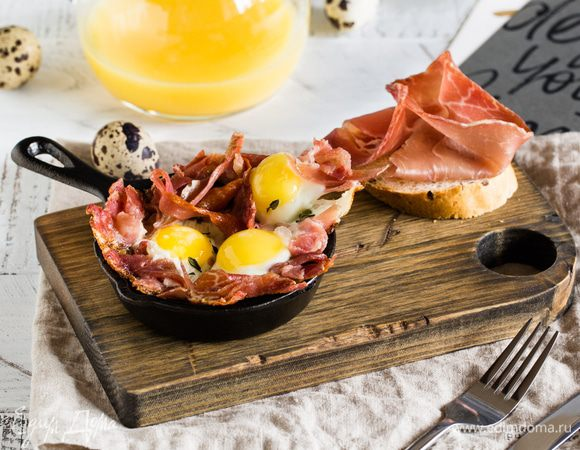